In [26]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [28]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [29]:
combined_ds = combine_birds(
    NumpyDataset(data_raw, labels), 
    sequence_length=300,
    random_seed=42
)
print(f'{combined_ds.data.shape = }')
print(f'{combined_ds.labels.shape = }')

Creating random sequence from 1 duplicates:  50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 59879/120000 [00:36<00:36, 1629.25it/s]


KeyboardInterrupt: 

# Hyper Parameters

In [21]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=1,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[64, 48, 48, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [22]:
def create_training_hyper_parameters(
    num_epochs: Union[int, float], 
    initial_lr: float,
    lr_scheduler_milestones: list[Union[int, float]],
    lr_scheduler_gamma: float
):
    return TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 1.35, # 0
            1.0, # 1
            1.0 / 1.5, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(num_epochs),
        
        lr=initial_lr,
        lr_scheduler_milestones=[int(m) for m in lr_scheduler_milestones],
        lr_scheduler_gamma=lr_scheduler_gamma,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Creating 8 folds
Executing CV for fold 0
Training fold 0
Training AttentionClassifier with 62523 parameters
train label counts = [74723, 5039, 7801, 7154, 2028, 4523, 3732]
loss weights = [0.74, 14.83, 6.39, 10.44, 36.85, 16.52, 20.02]
eval label counts = [10635, 794, 1153, 1044, 296, 588, 490]
eval loss weights = [0.74, 13.39, 6.15, 10.19, 35.93, 18.09, 21.7]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  6882, acc = 0.065543, bacc = 0.144263
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000279, num_samples = 15000, num_correct =  1044, acc = 0.069600, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000204, num_samples = 105000, num_correct =  7123, acc = 0.067838, bacc = 0.143435
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000279, num_samples = 15000, num_correct =   822, acc = 0.054800, bacc = 0.134552
Training Epoch   3/300: lr = 1.00E-03, epoch =     3, avg_loss = 

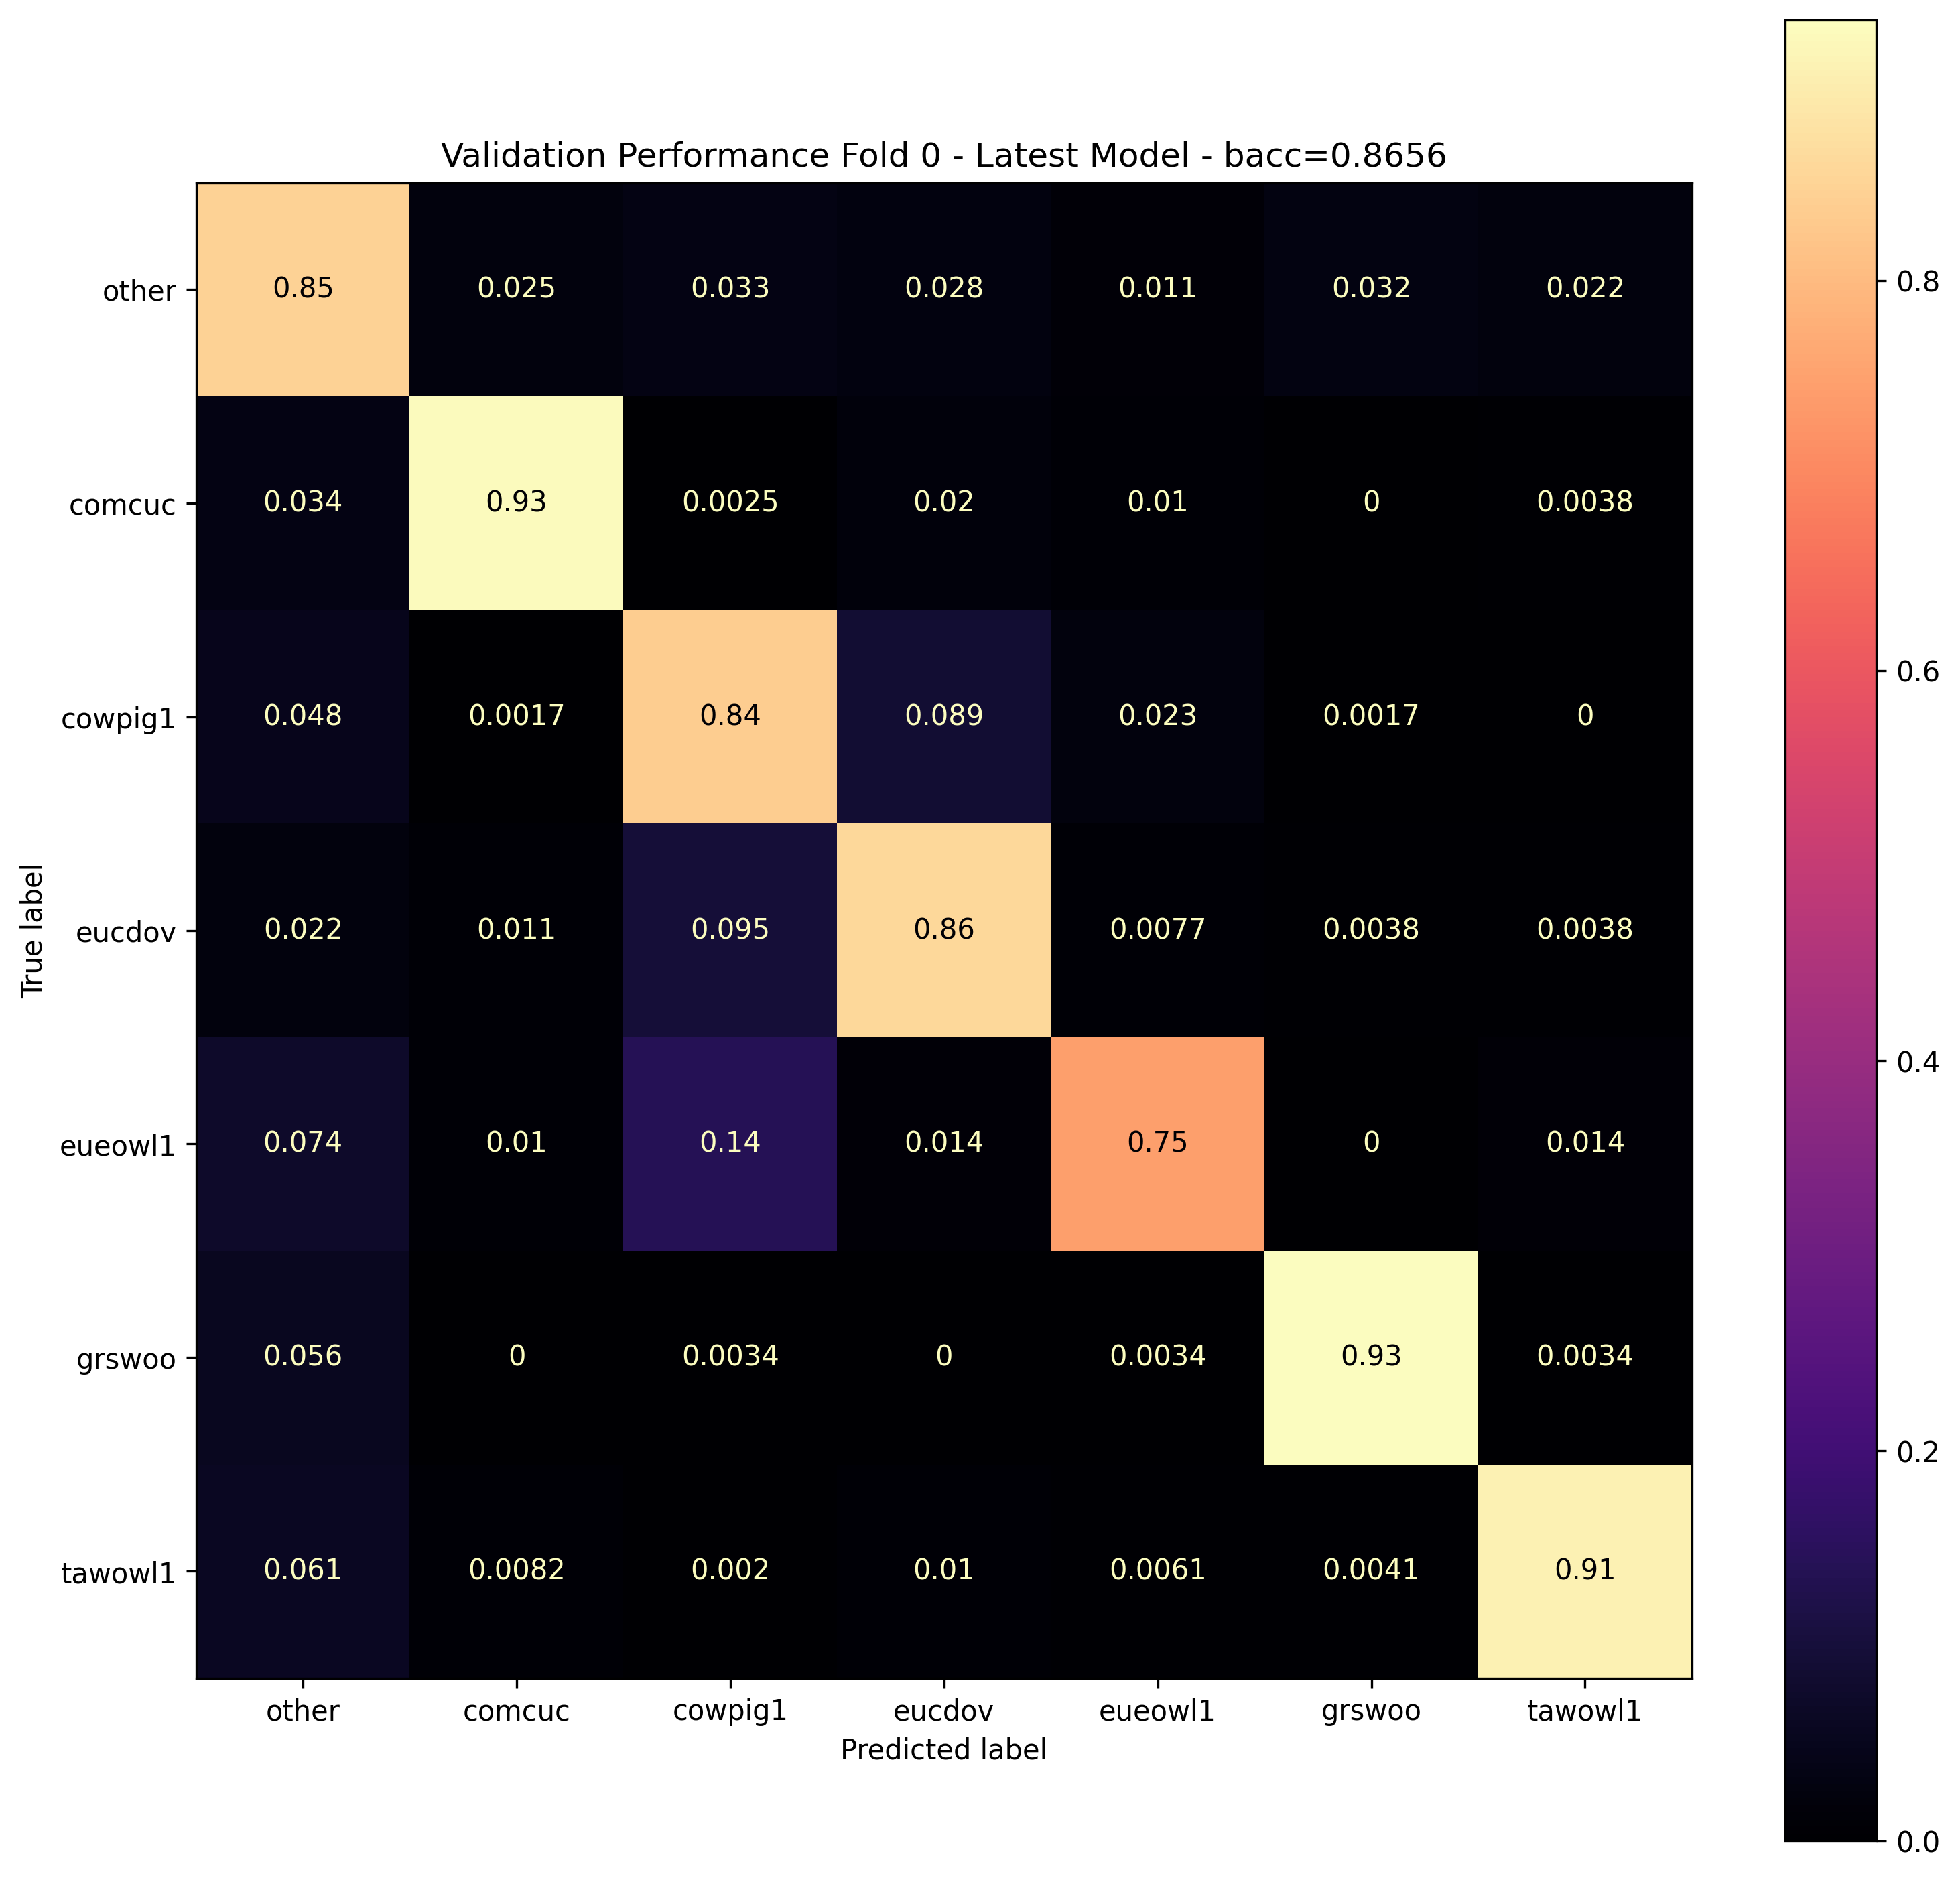

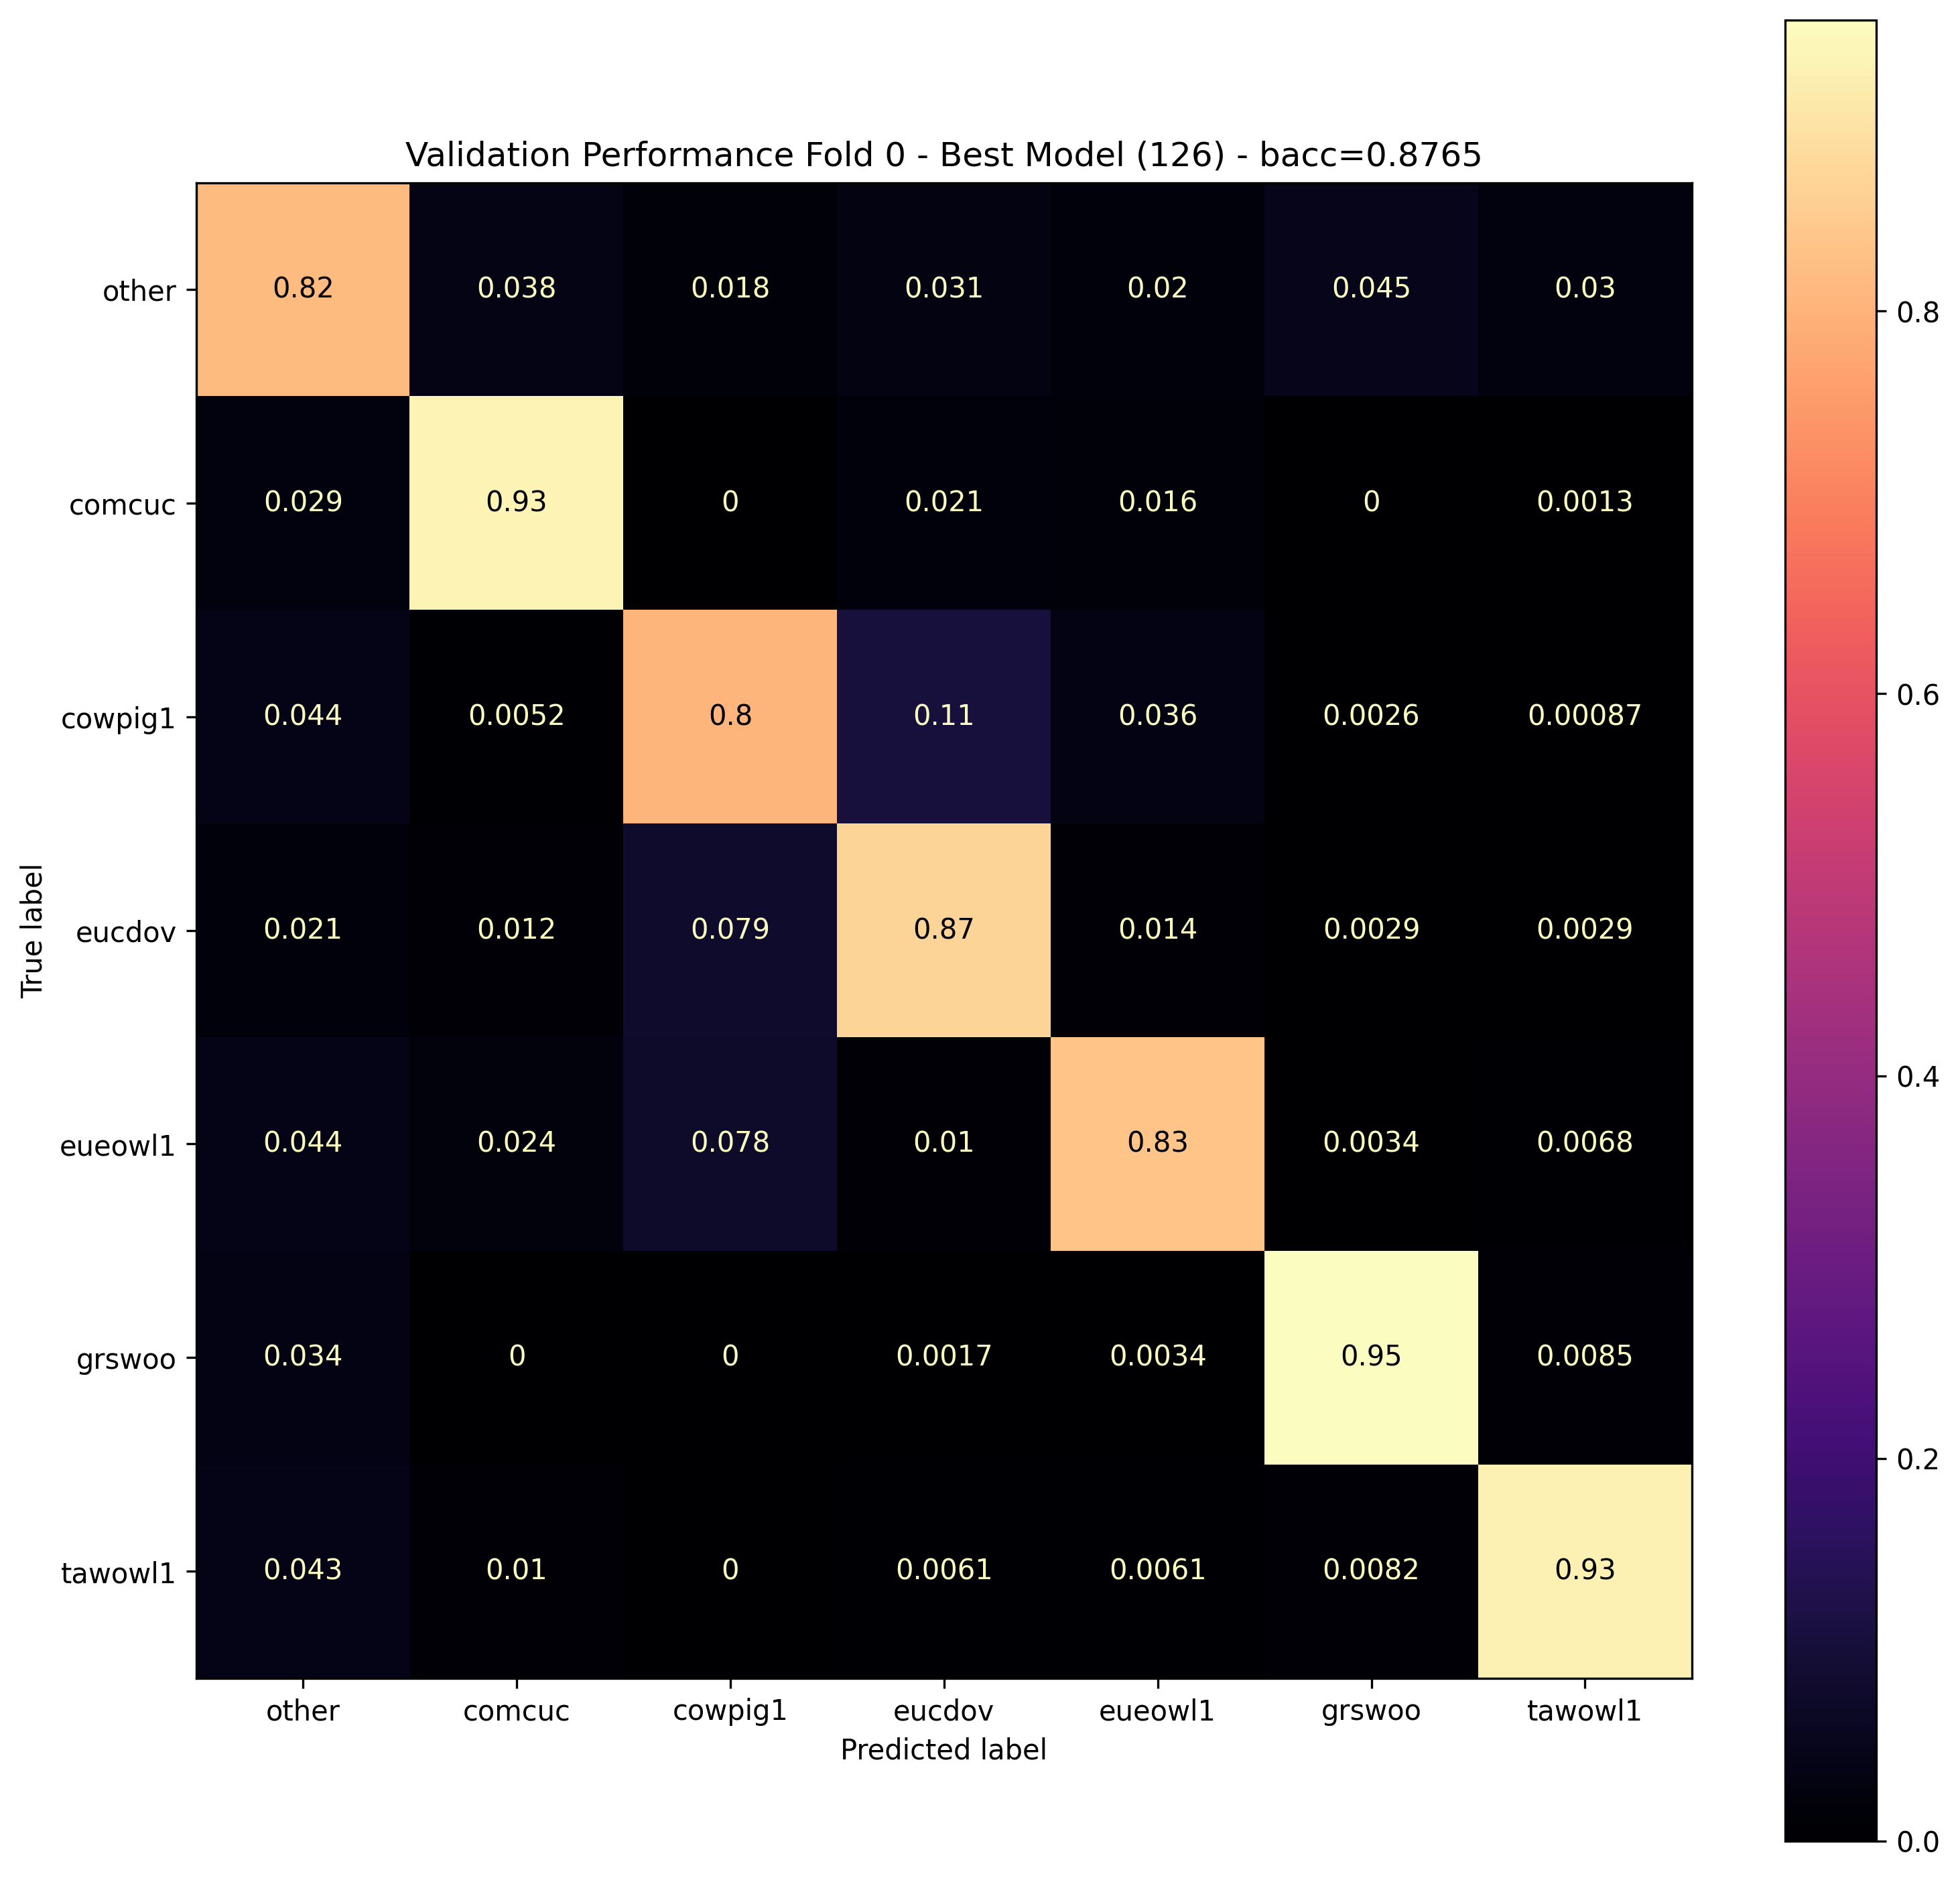

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-0-best train-bacc=0.9453 eval-bacc=0.8765"
Executing CV for fold 1
Training fold 1
Training AttentionClassifier with 62523 parameters
train label counts = [74588, 5128, 7851, 7318, 1988, 4415, 3712]
loss weights = [0.74, 14.55, 6.33, 10.19, 37.52, 16.89, 20.09]
eval label counts = [10770, 705, 1103, 880, 336, 696, 510]
eval loss weights = [0.74, 15.28, 6.51, 12.24, 32.05, 15.47, 21.12]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000206, num_samples = 105000, num_correct = 16011, acc = 0.152486, bacc = 0.143742
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000251, num_samples = 15000, num_correct =   510, acc = 0.034000, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000204, num_samples = 105000, num_correct =  3937, acc = 0.037495, bacc = 0.143023
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000257, num_samples = 15000, num_correct =   682

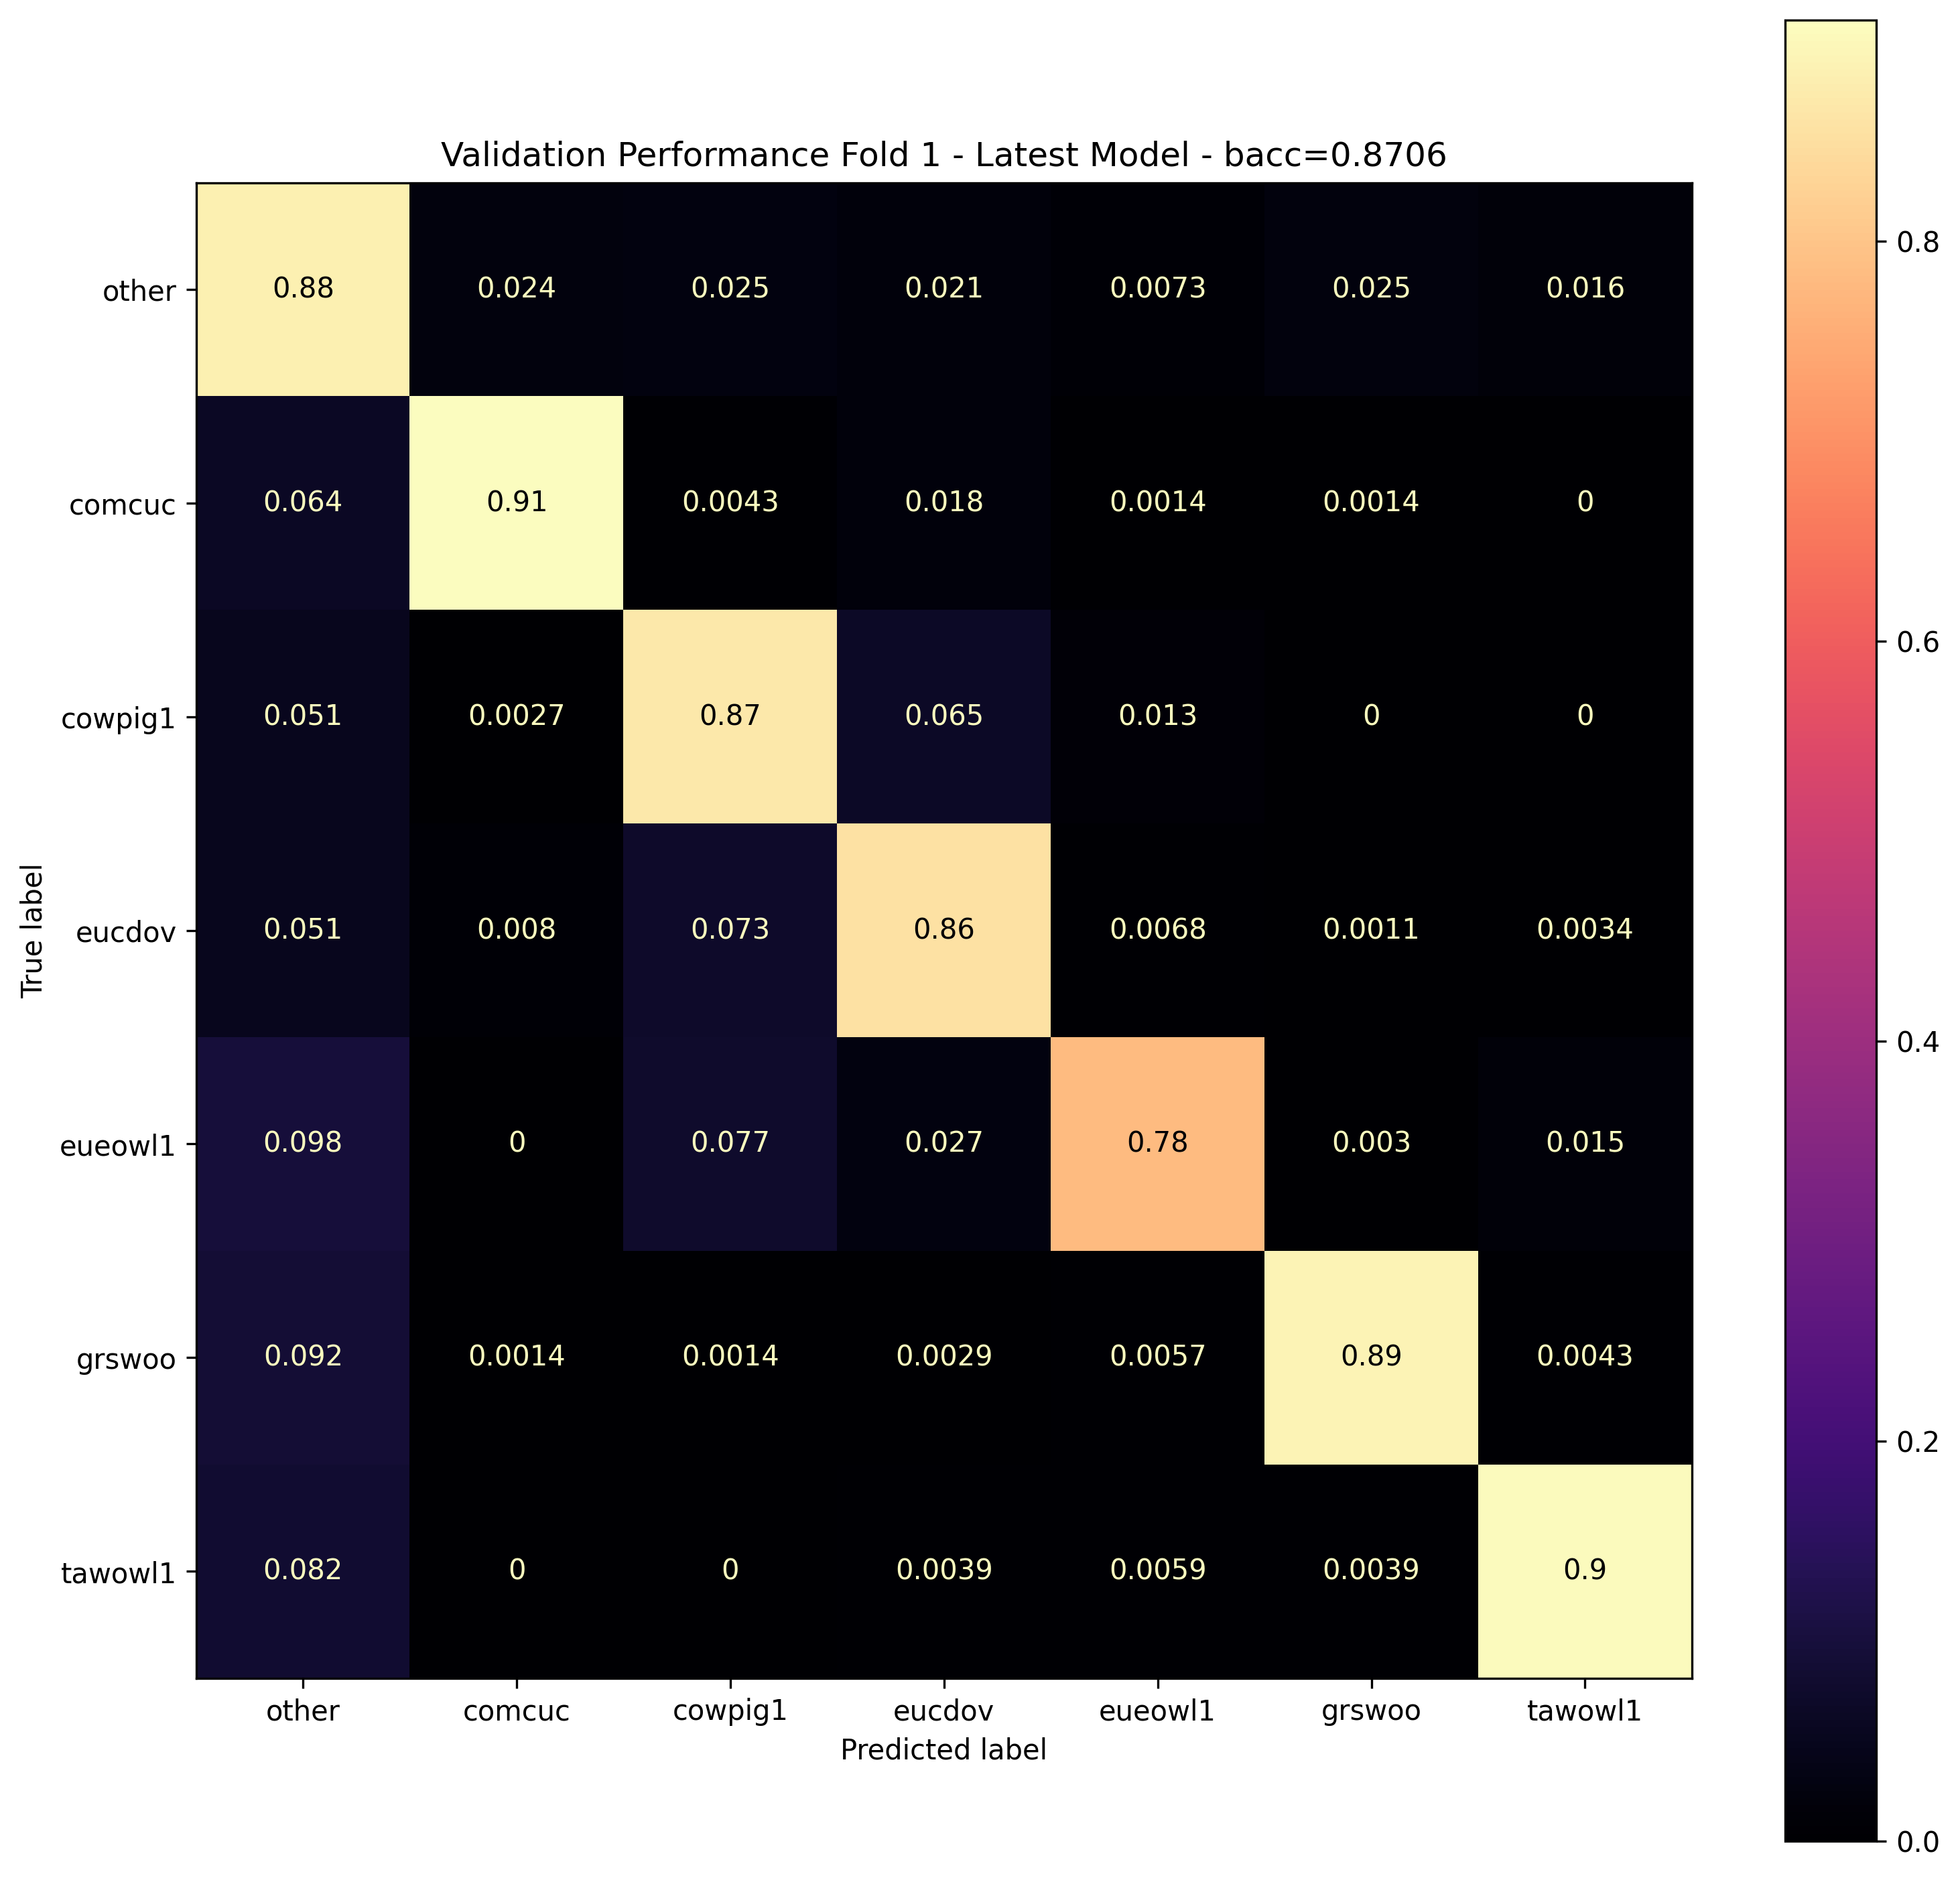

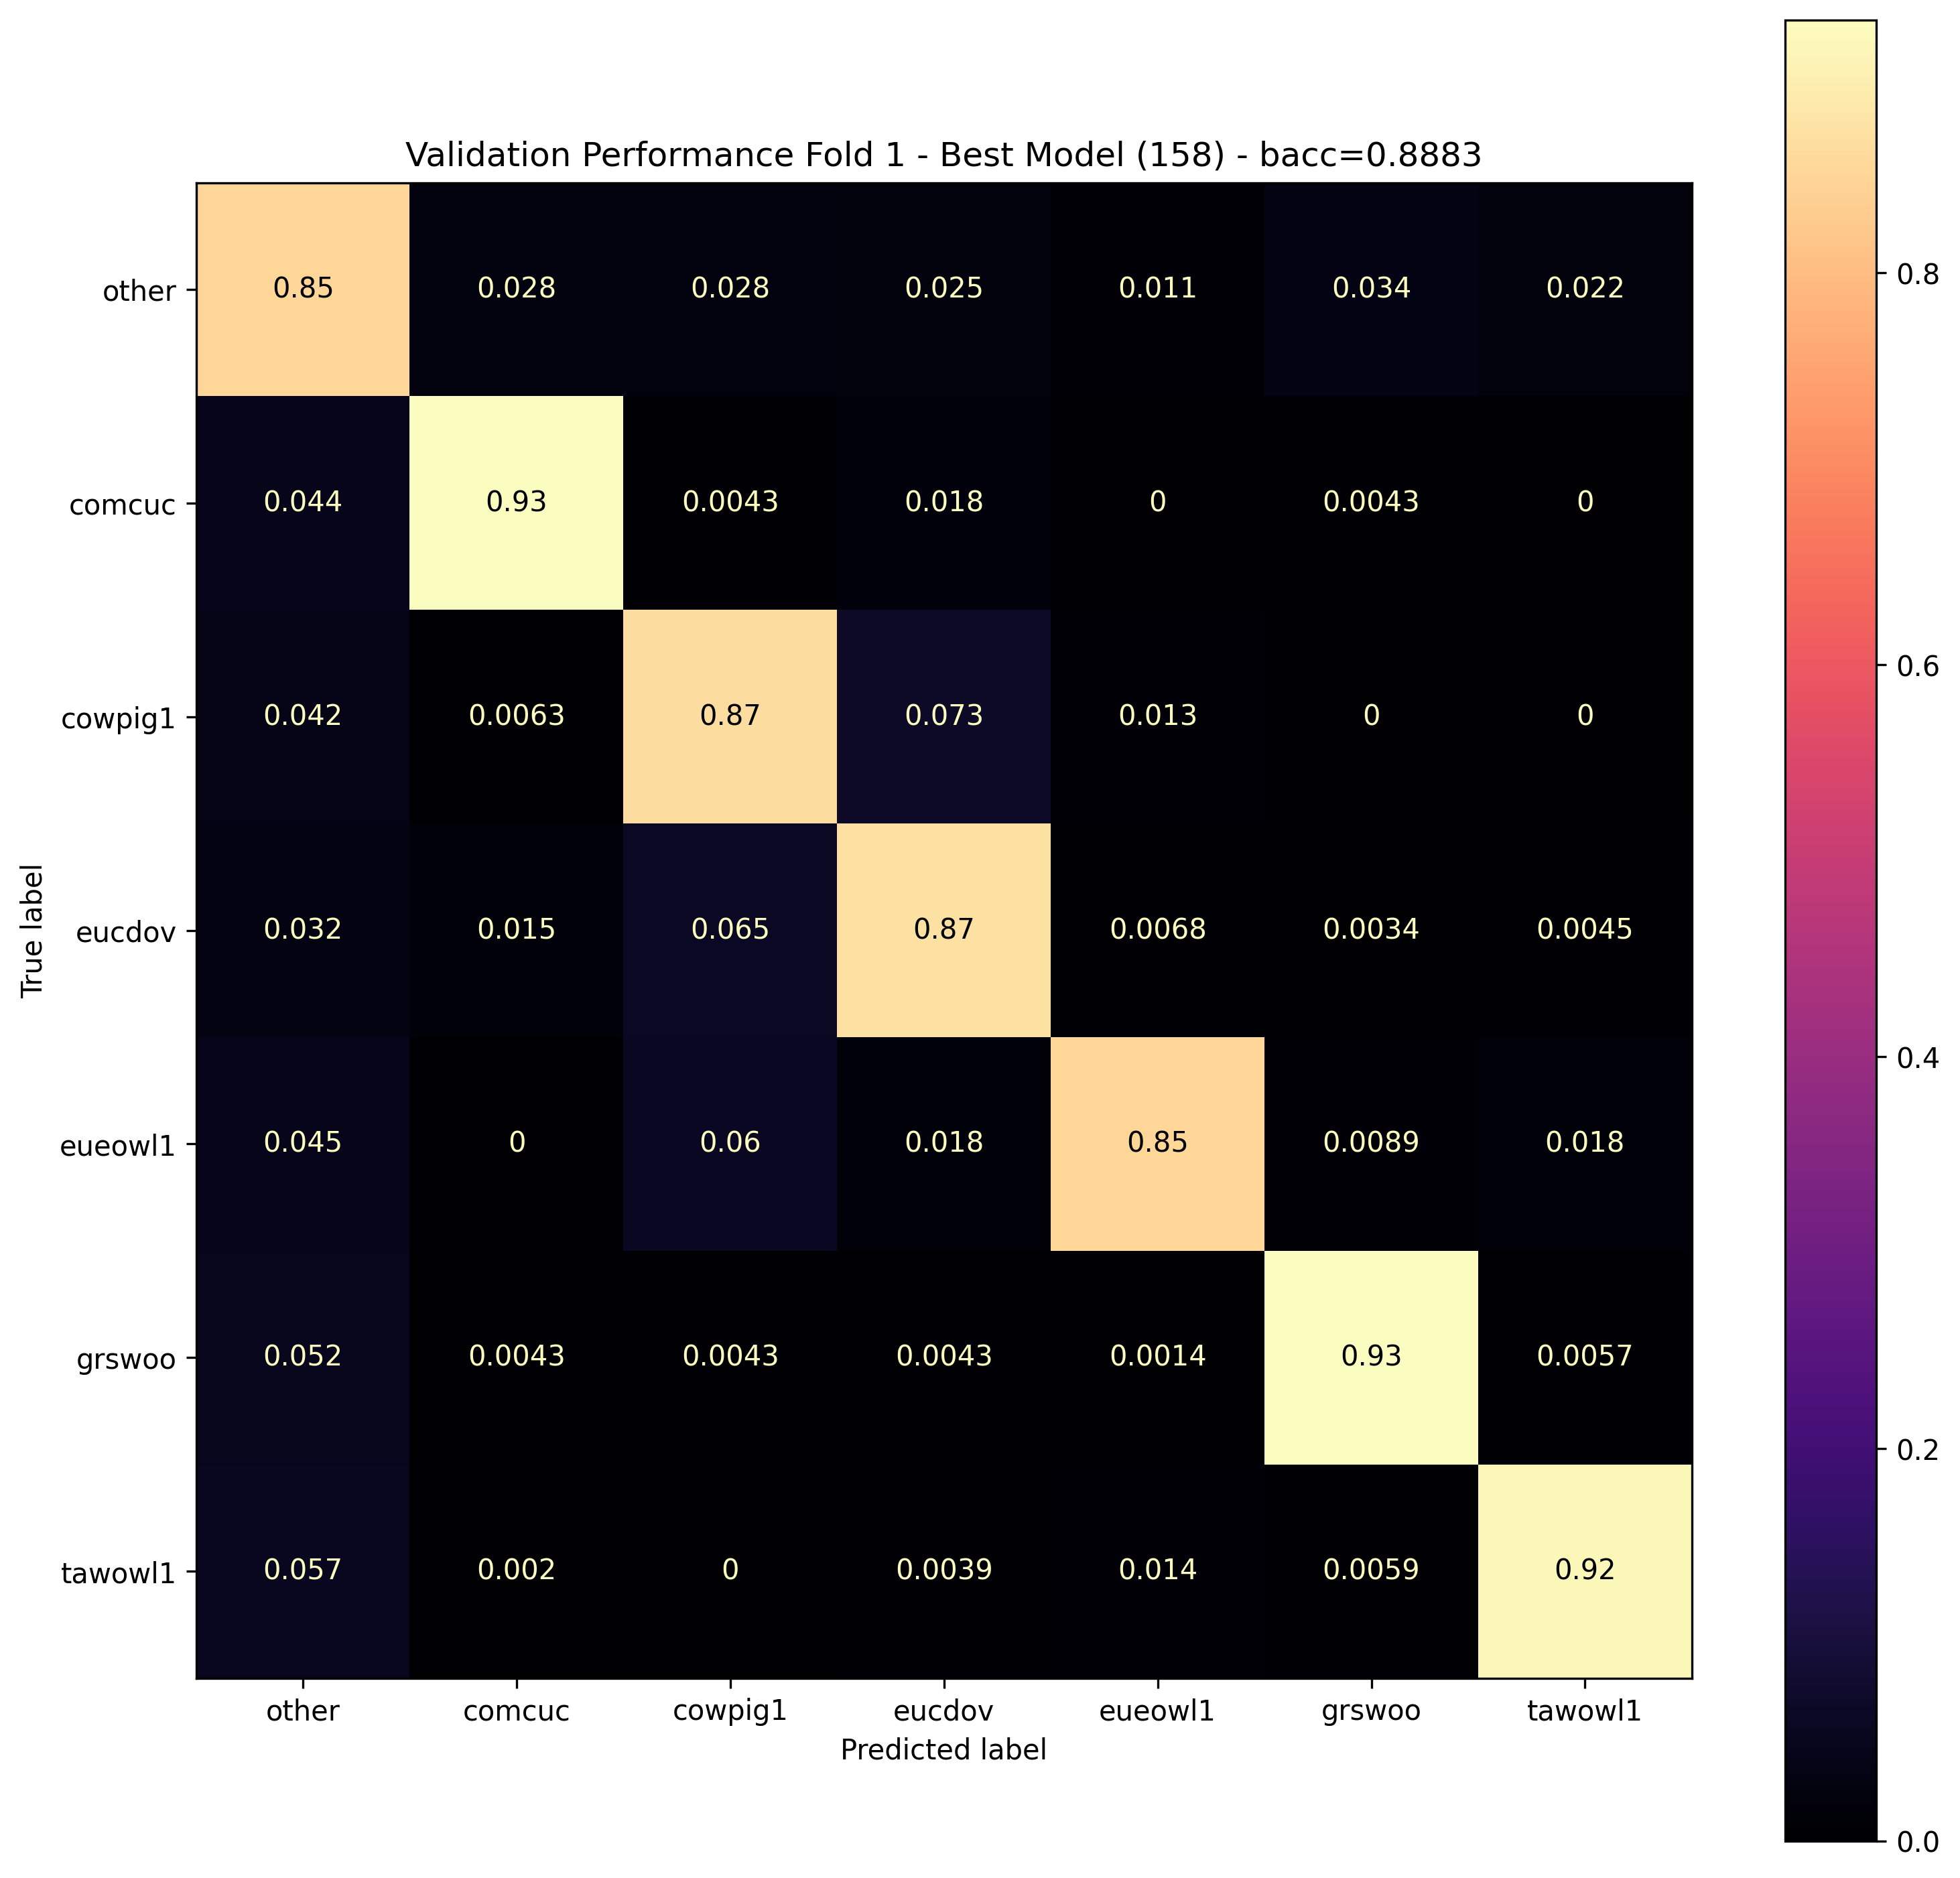

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-1-best train-bacc=0.9666 eval-bacc=0.8883"
Executing CV for fold 2
Training fold 2
Training AttentionClassifier with 62523 parameters
train label counts = [74588, 4883, 8001, 7214, 1994, 4517, 3803]
loss weights = [0.74, 15.28, 6.21, 10.34, 37.41, 16.51, 19.61]
eval label counts = [10770, 950, 953, 984, 330, 594, 419]
eval loss weights = [0.74, 11.34, 7.53, 10.95, 32.64, 18.13, 25.7]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000208, num_samples = 105000, num_correct = 60046, acc = 0.571867, bacc = 0.140825
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000239, num_samples = 15000, num_correct = 10770, acc = 0.718000, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000206, num_samples = 105000, num_correct = 74588, acc = 0.710362, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000244, num_samples = 15000, num_correct = 10770, 

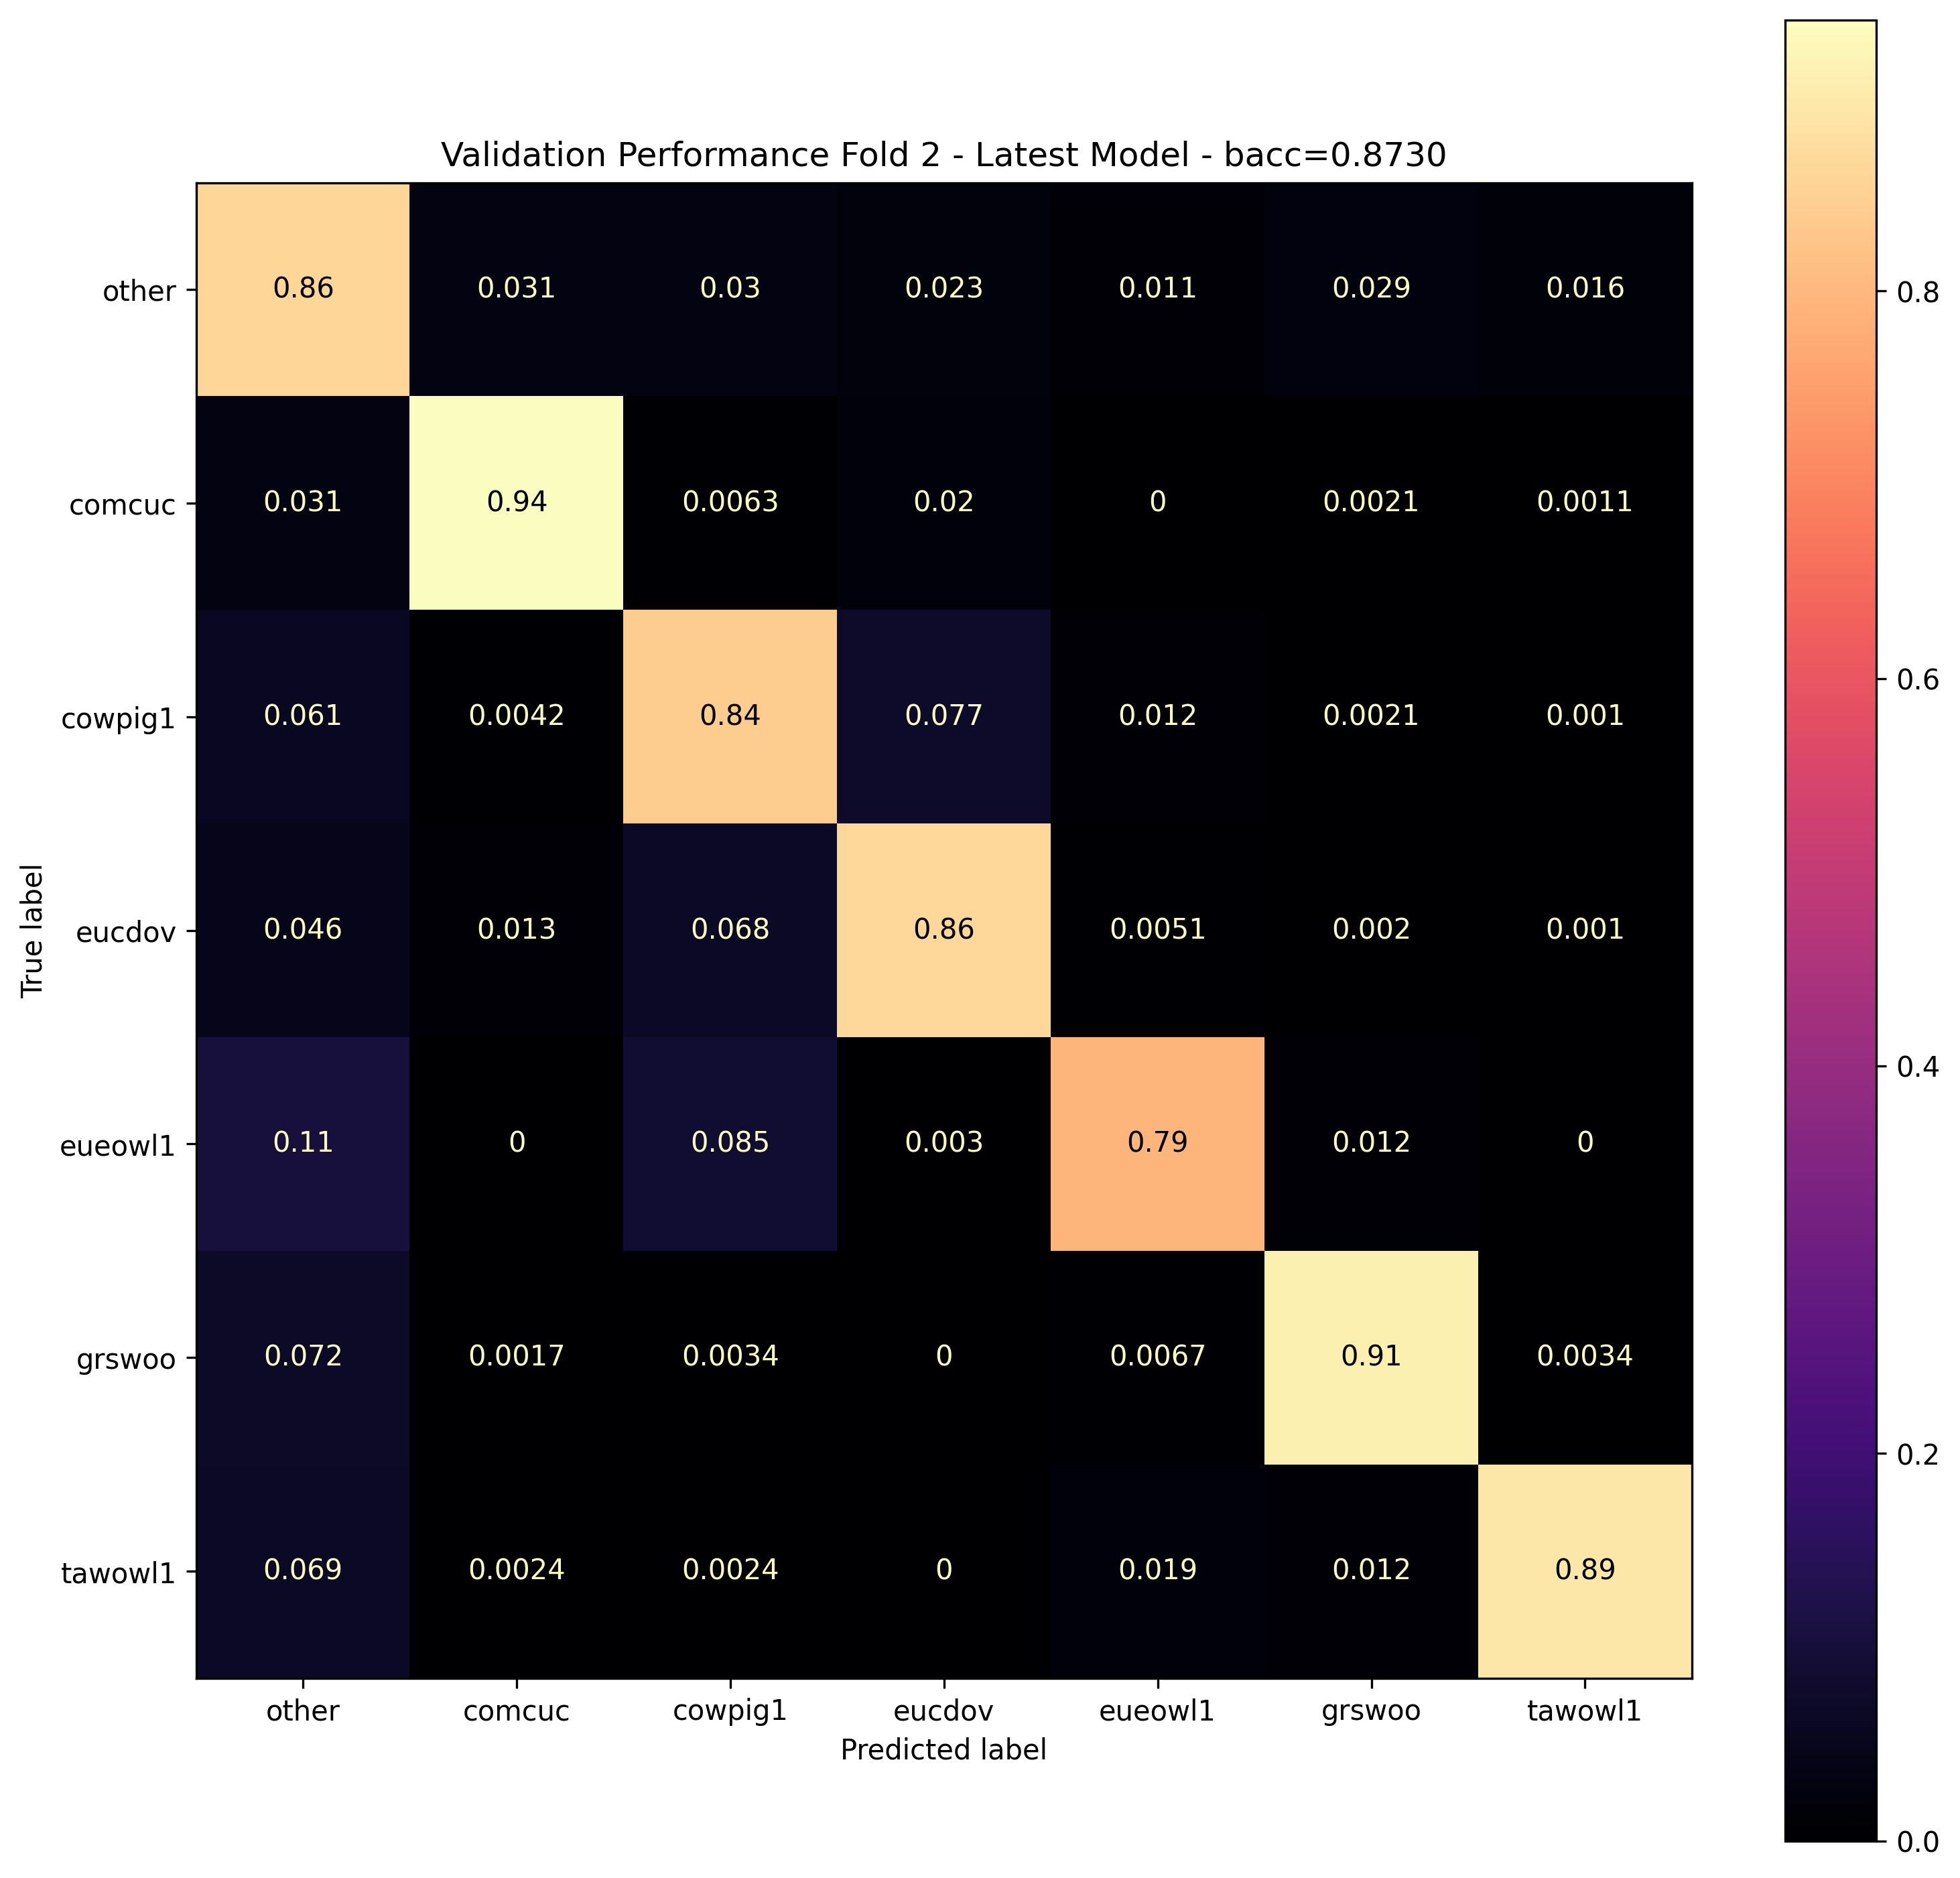

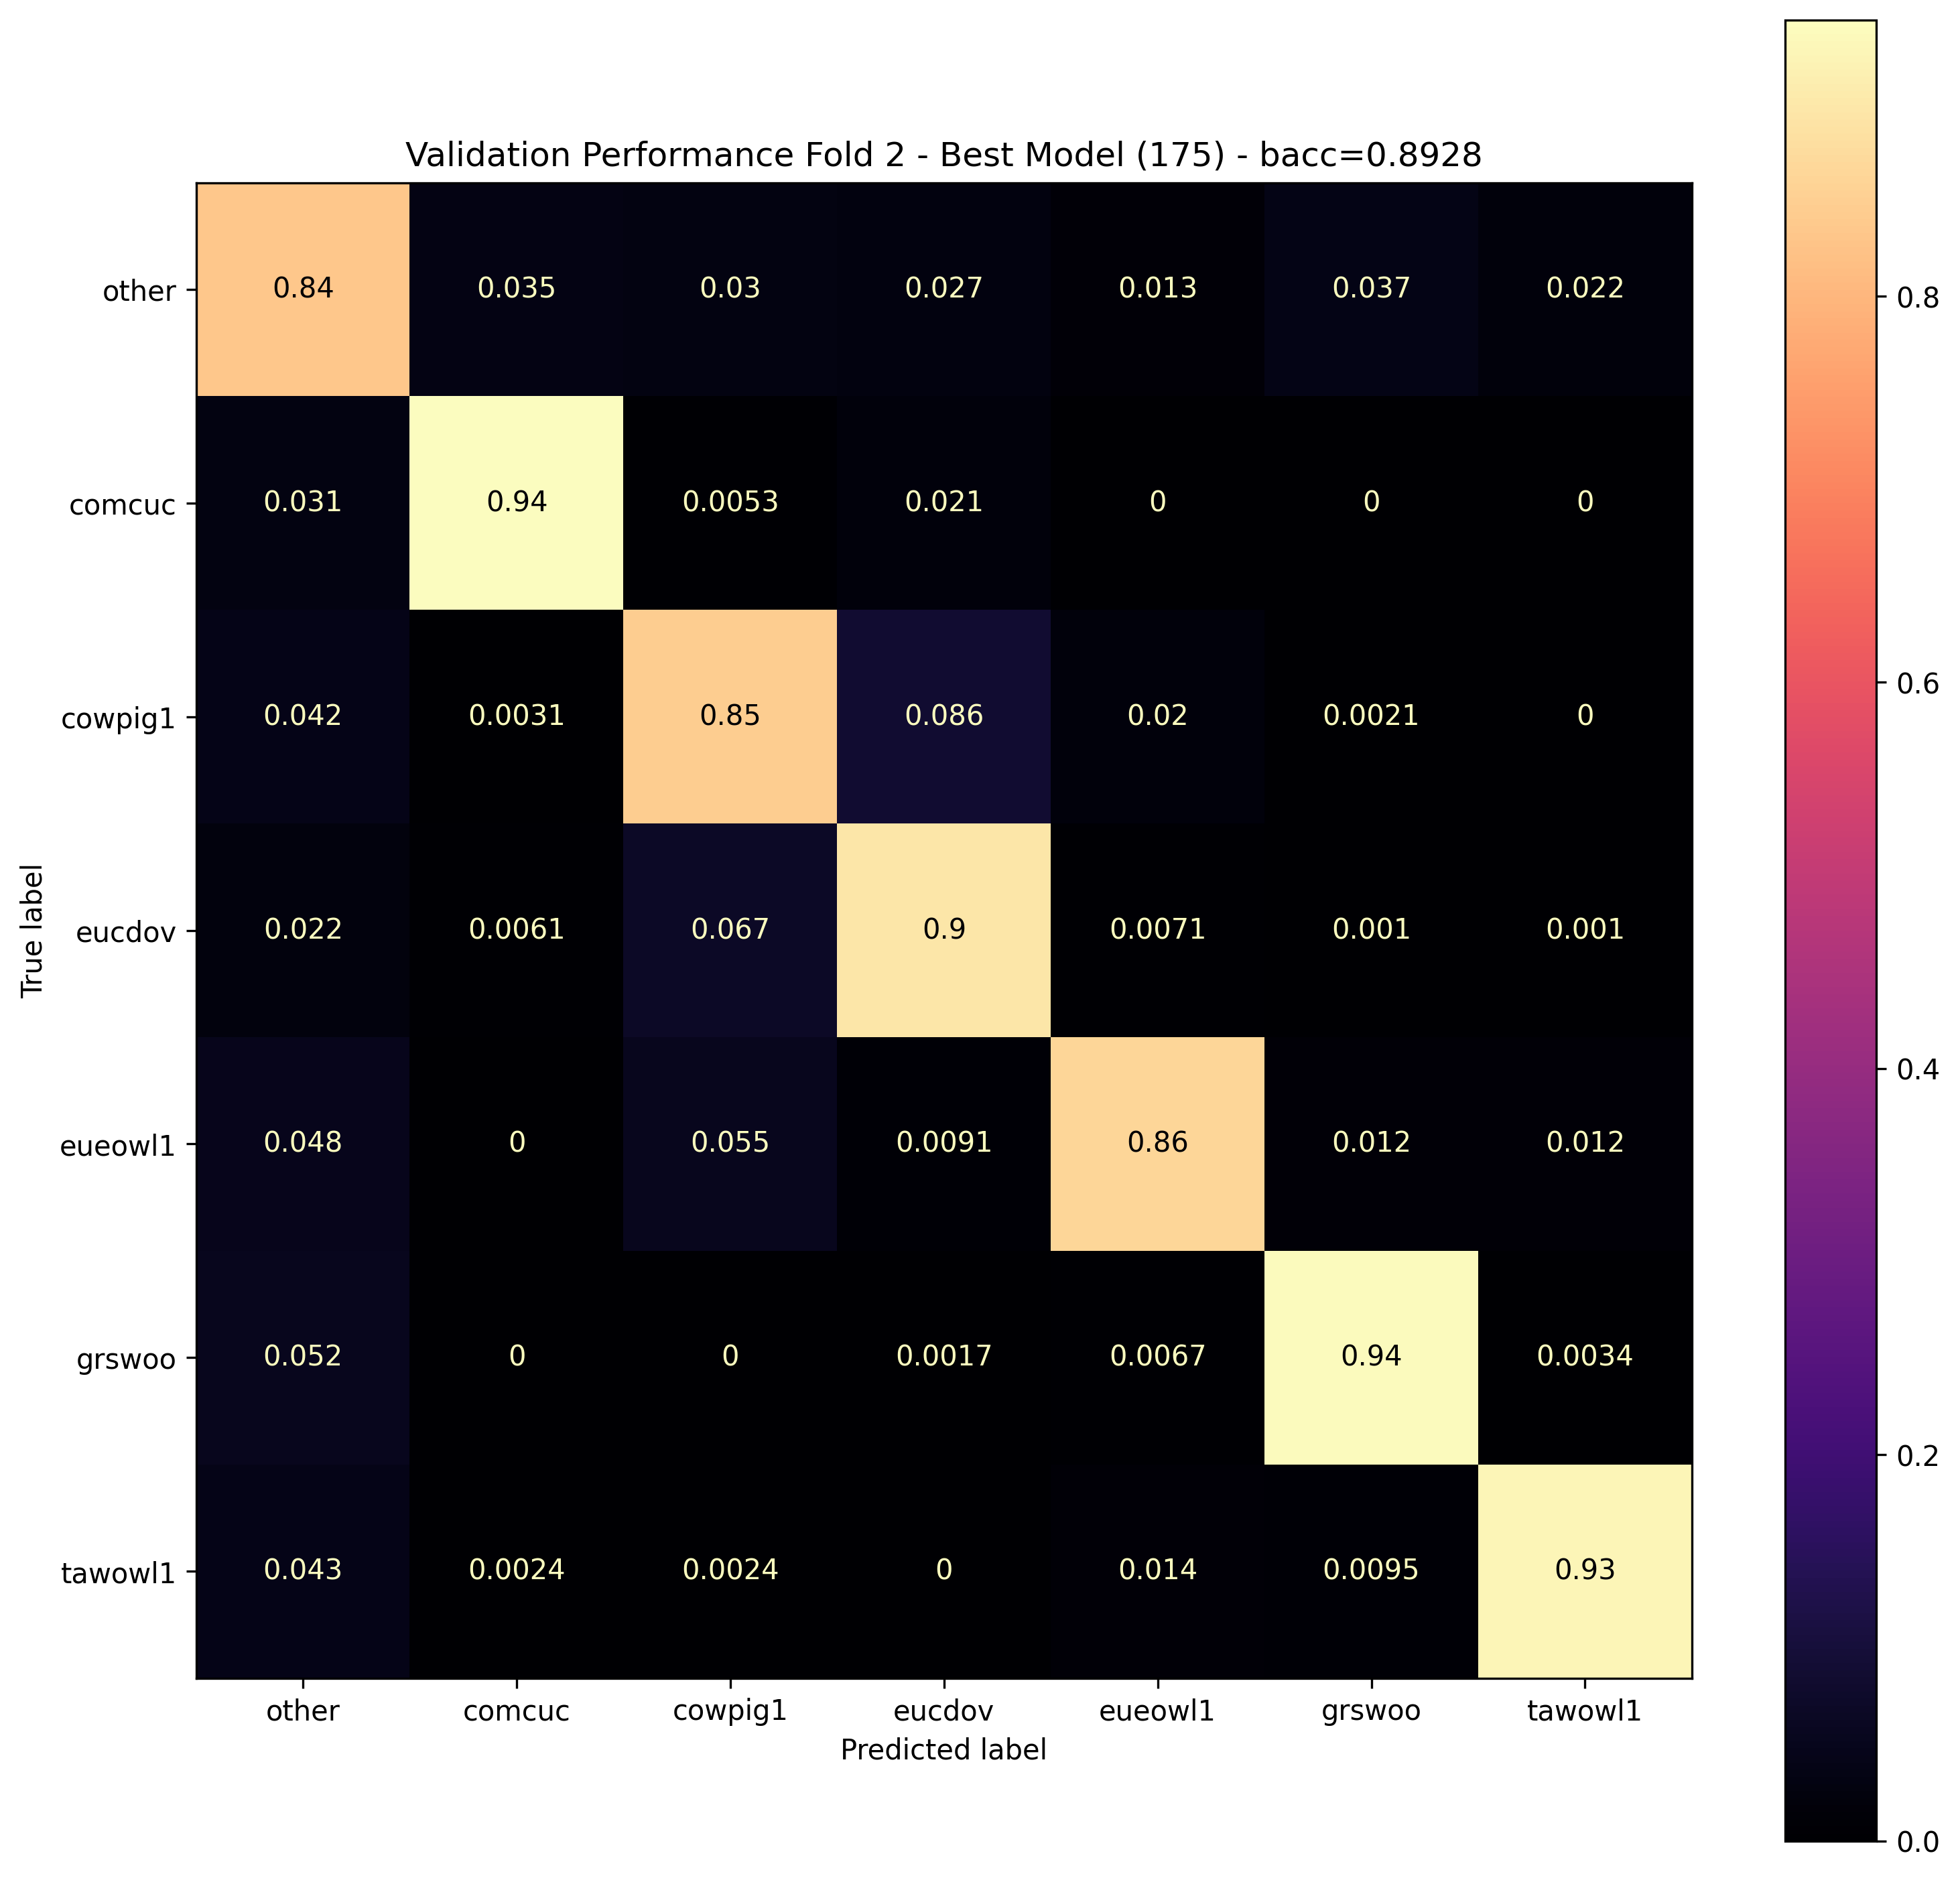

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-2-best train-bacc=0.9685 eval-bacc=0.8928"
Executing CV for fold 3
Training fold 3
Training AttentionClassifier with 62523 parameters
train label counts = [74633, 4970, 8084, 7021, 2066, 4603, 3623]
loss weights = [0.74, 15.02, 6.15, 10.63, 36.12, 16.21, 20.6]
eval label counts = [10725, 863, 870, 1177, 258, 508, 599]
eval loss weights = [0.74, 12.43, 8.22, 9.11, 41.57, 21.11, 17.9]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000205, num_samples = 105000, num_correct = 22070, acc = 0.210190, bacc = 0.144915
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000254, num_samples = 15000, num_correct =   863, acc = 0.057533, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000204, num_samples = 105000, num_correct =  4970, acc = 0.047333, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000264, num_samples = 15000, num_correct =   863, a

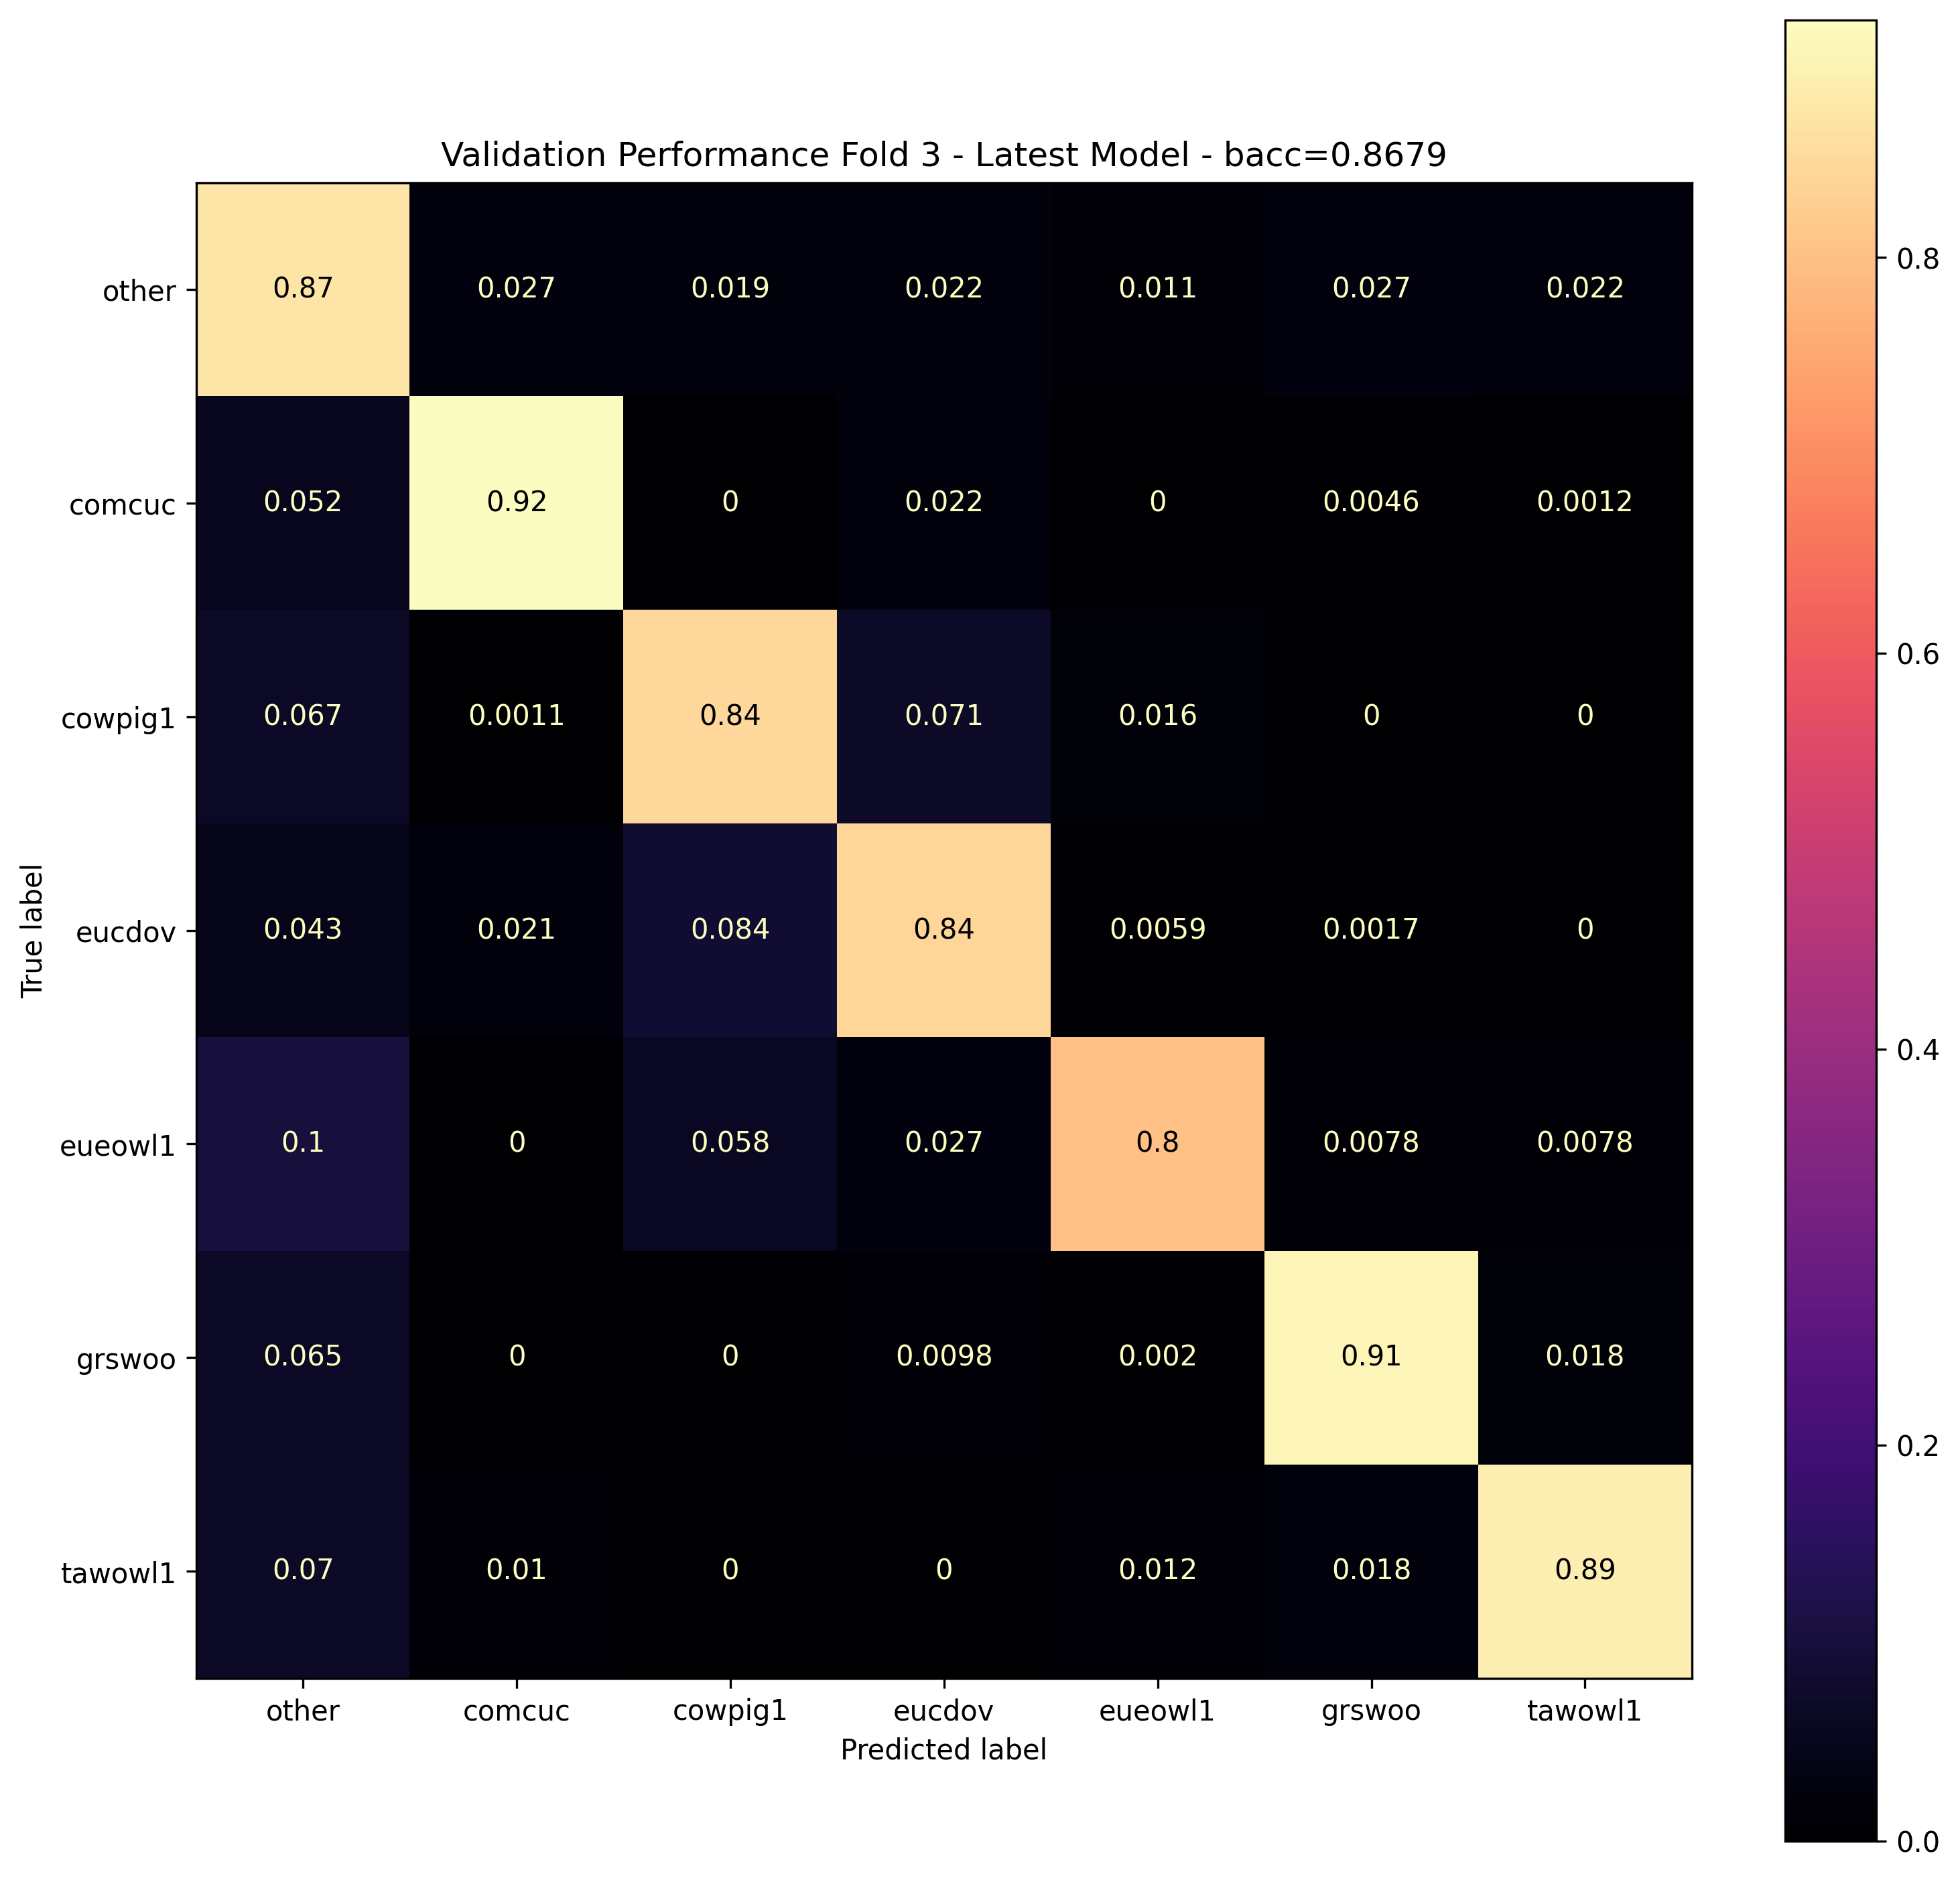

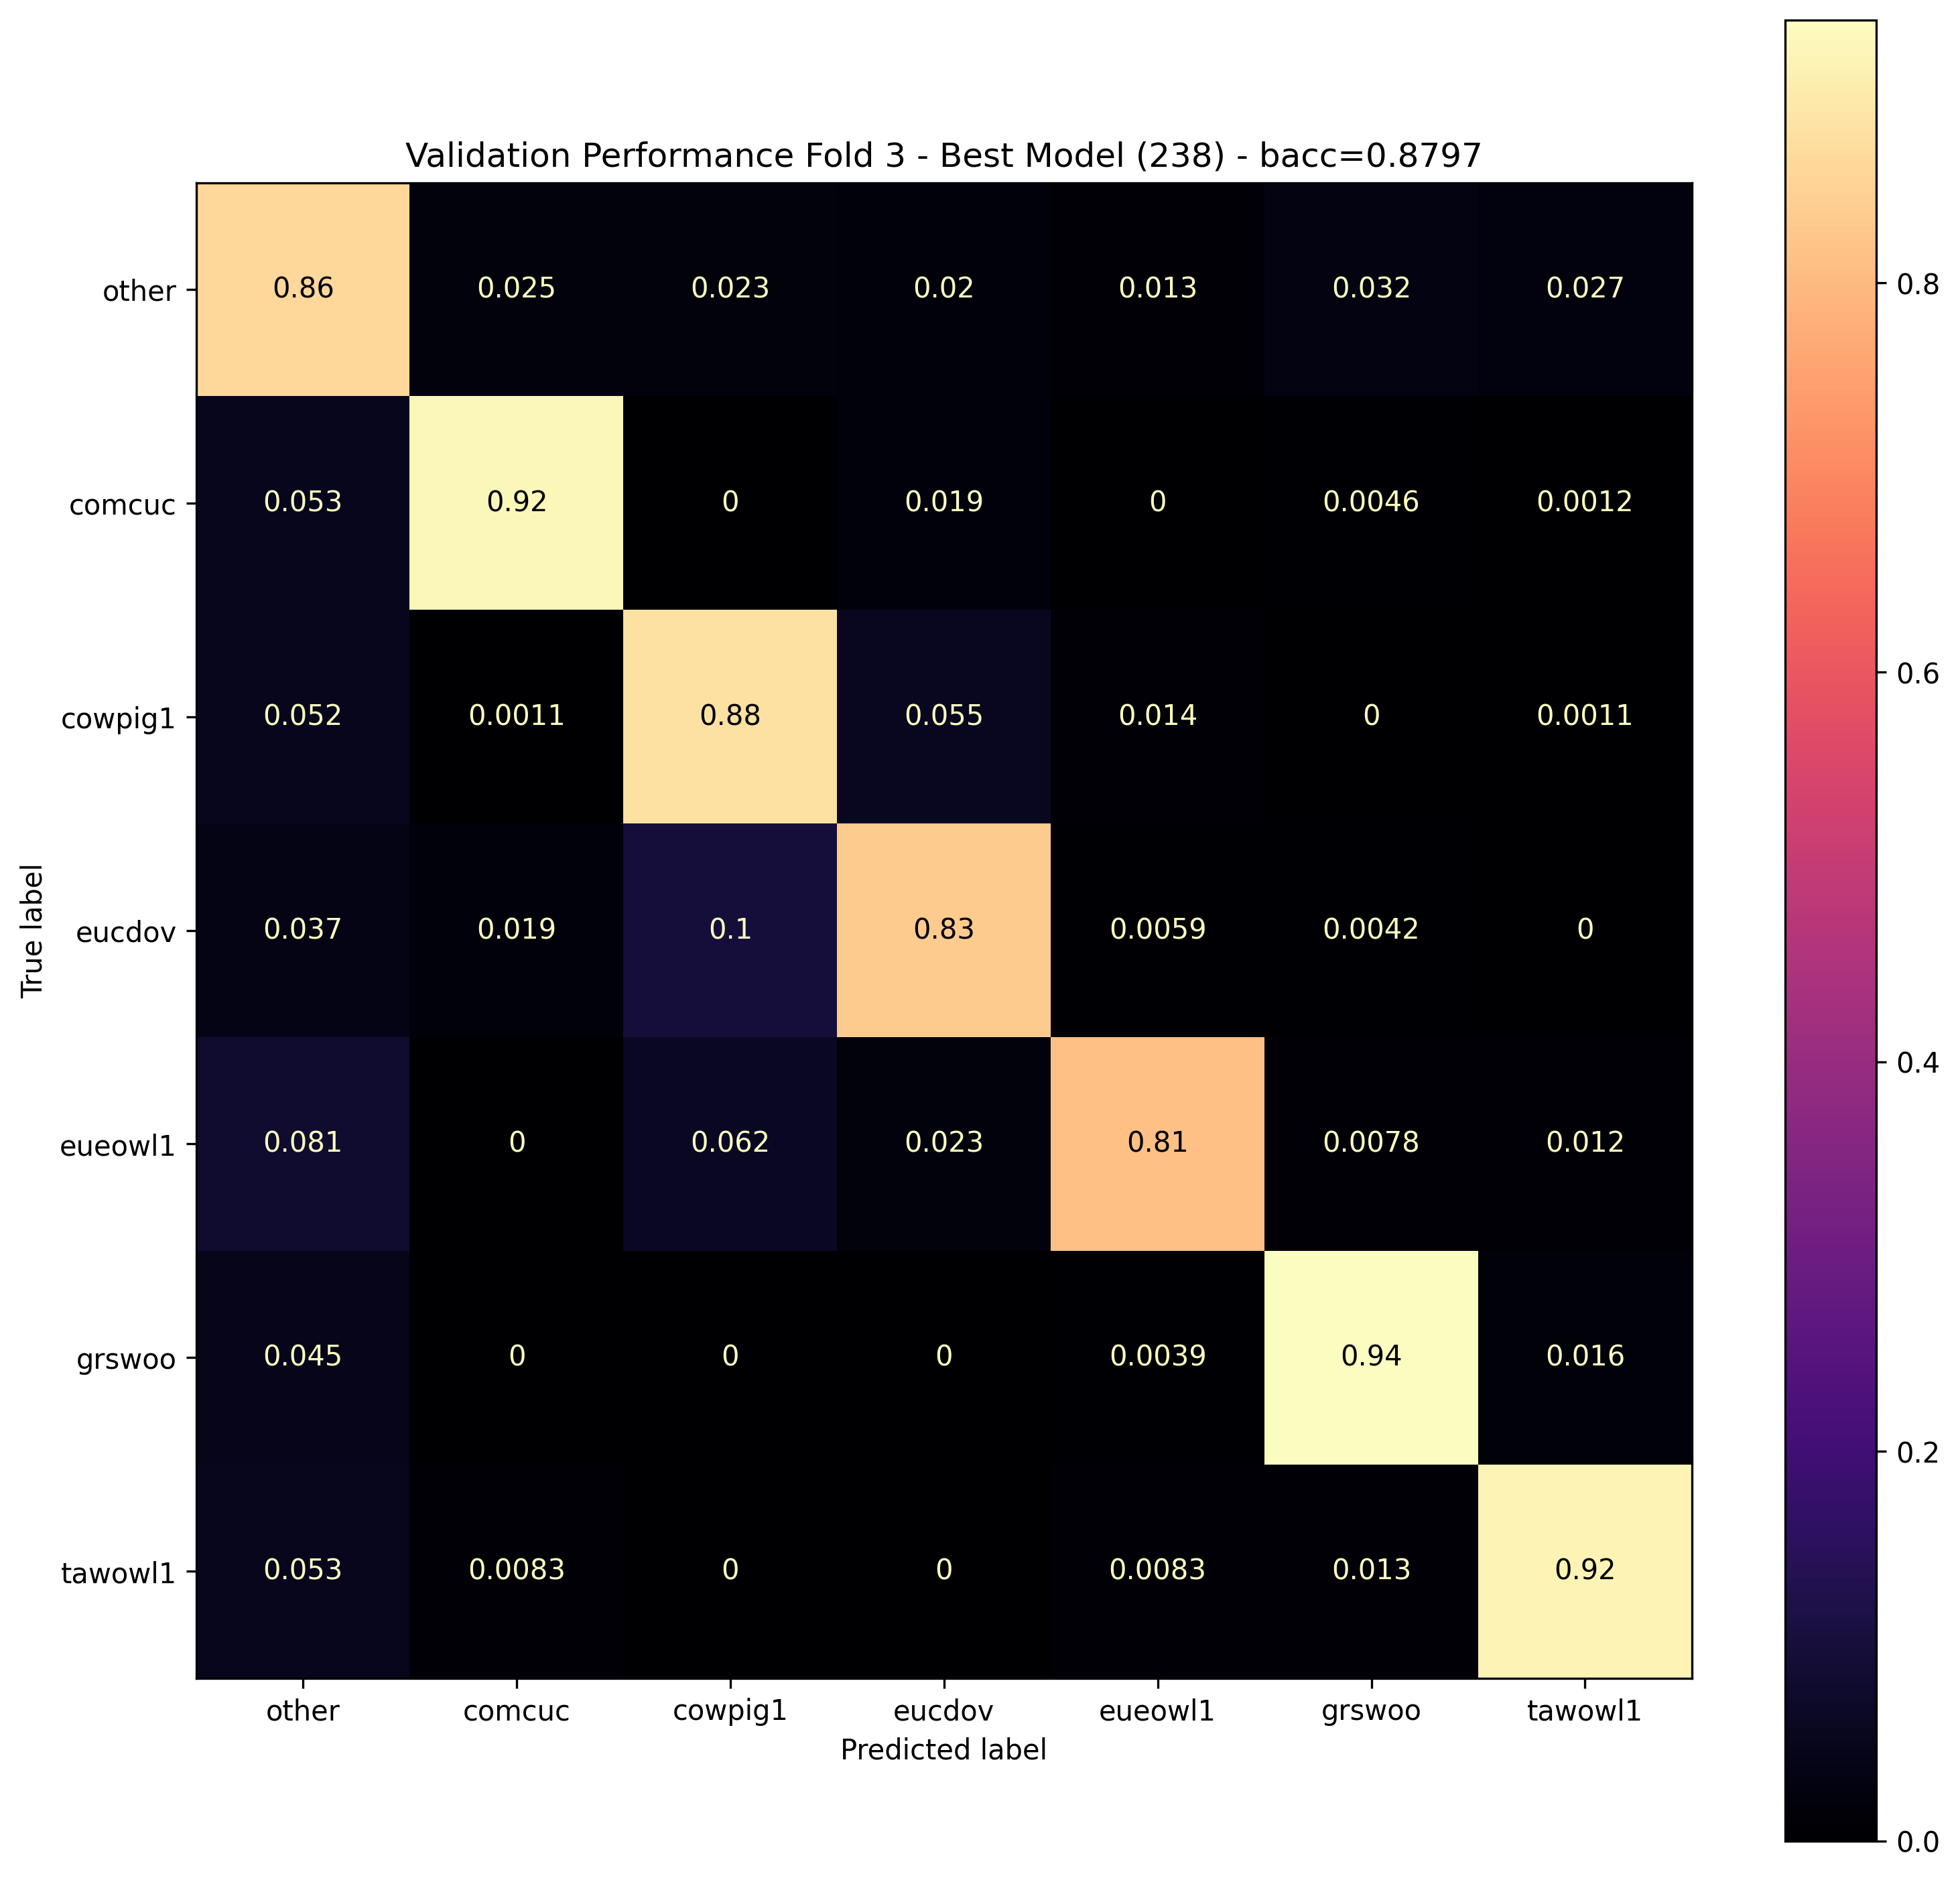

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-3-best train-bacc=0.9769 eval-bacc=0.8797"
Executing CV for fold 4
Training fold 4
Training AttentionClassifier with 62523 parameters
train label counts = [74836, 5089, 7800, 6906, 2009, 4573, 3787]
loss weights = [0.74, 14.71, 6.4, 10.84, 37.25, 16.36, 19.76]
eval label counts = [10522, 744, 1154, 1292, 315, 538, 435]
eval loss weights = [0.74, 14.14, 6.08, 8.14, 33.4, 19.56, 24.19]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  5076, acc = 0.048343, bacc = 0.142038
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000266, num_samples = 15000, num_correct =   435, acc = 0.029000, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000203, num_samples = 105000, num_correct =  3787, acc = 0.036067, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000271, num_samples = 15000, num_correct =   435, 

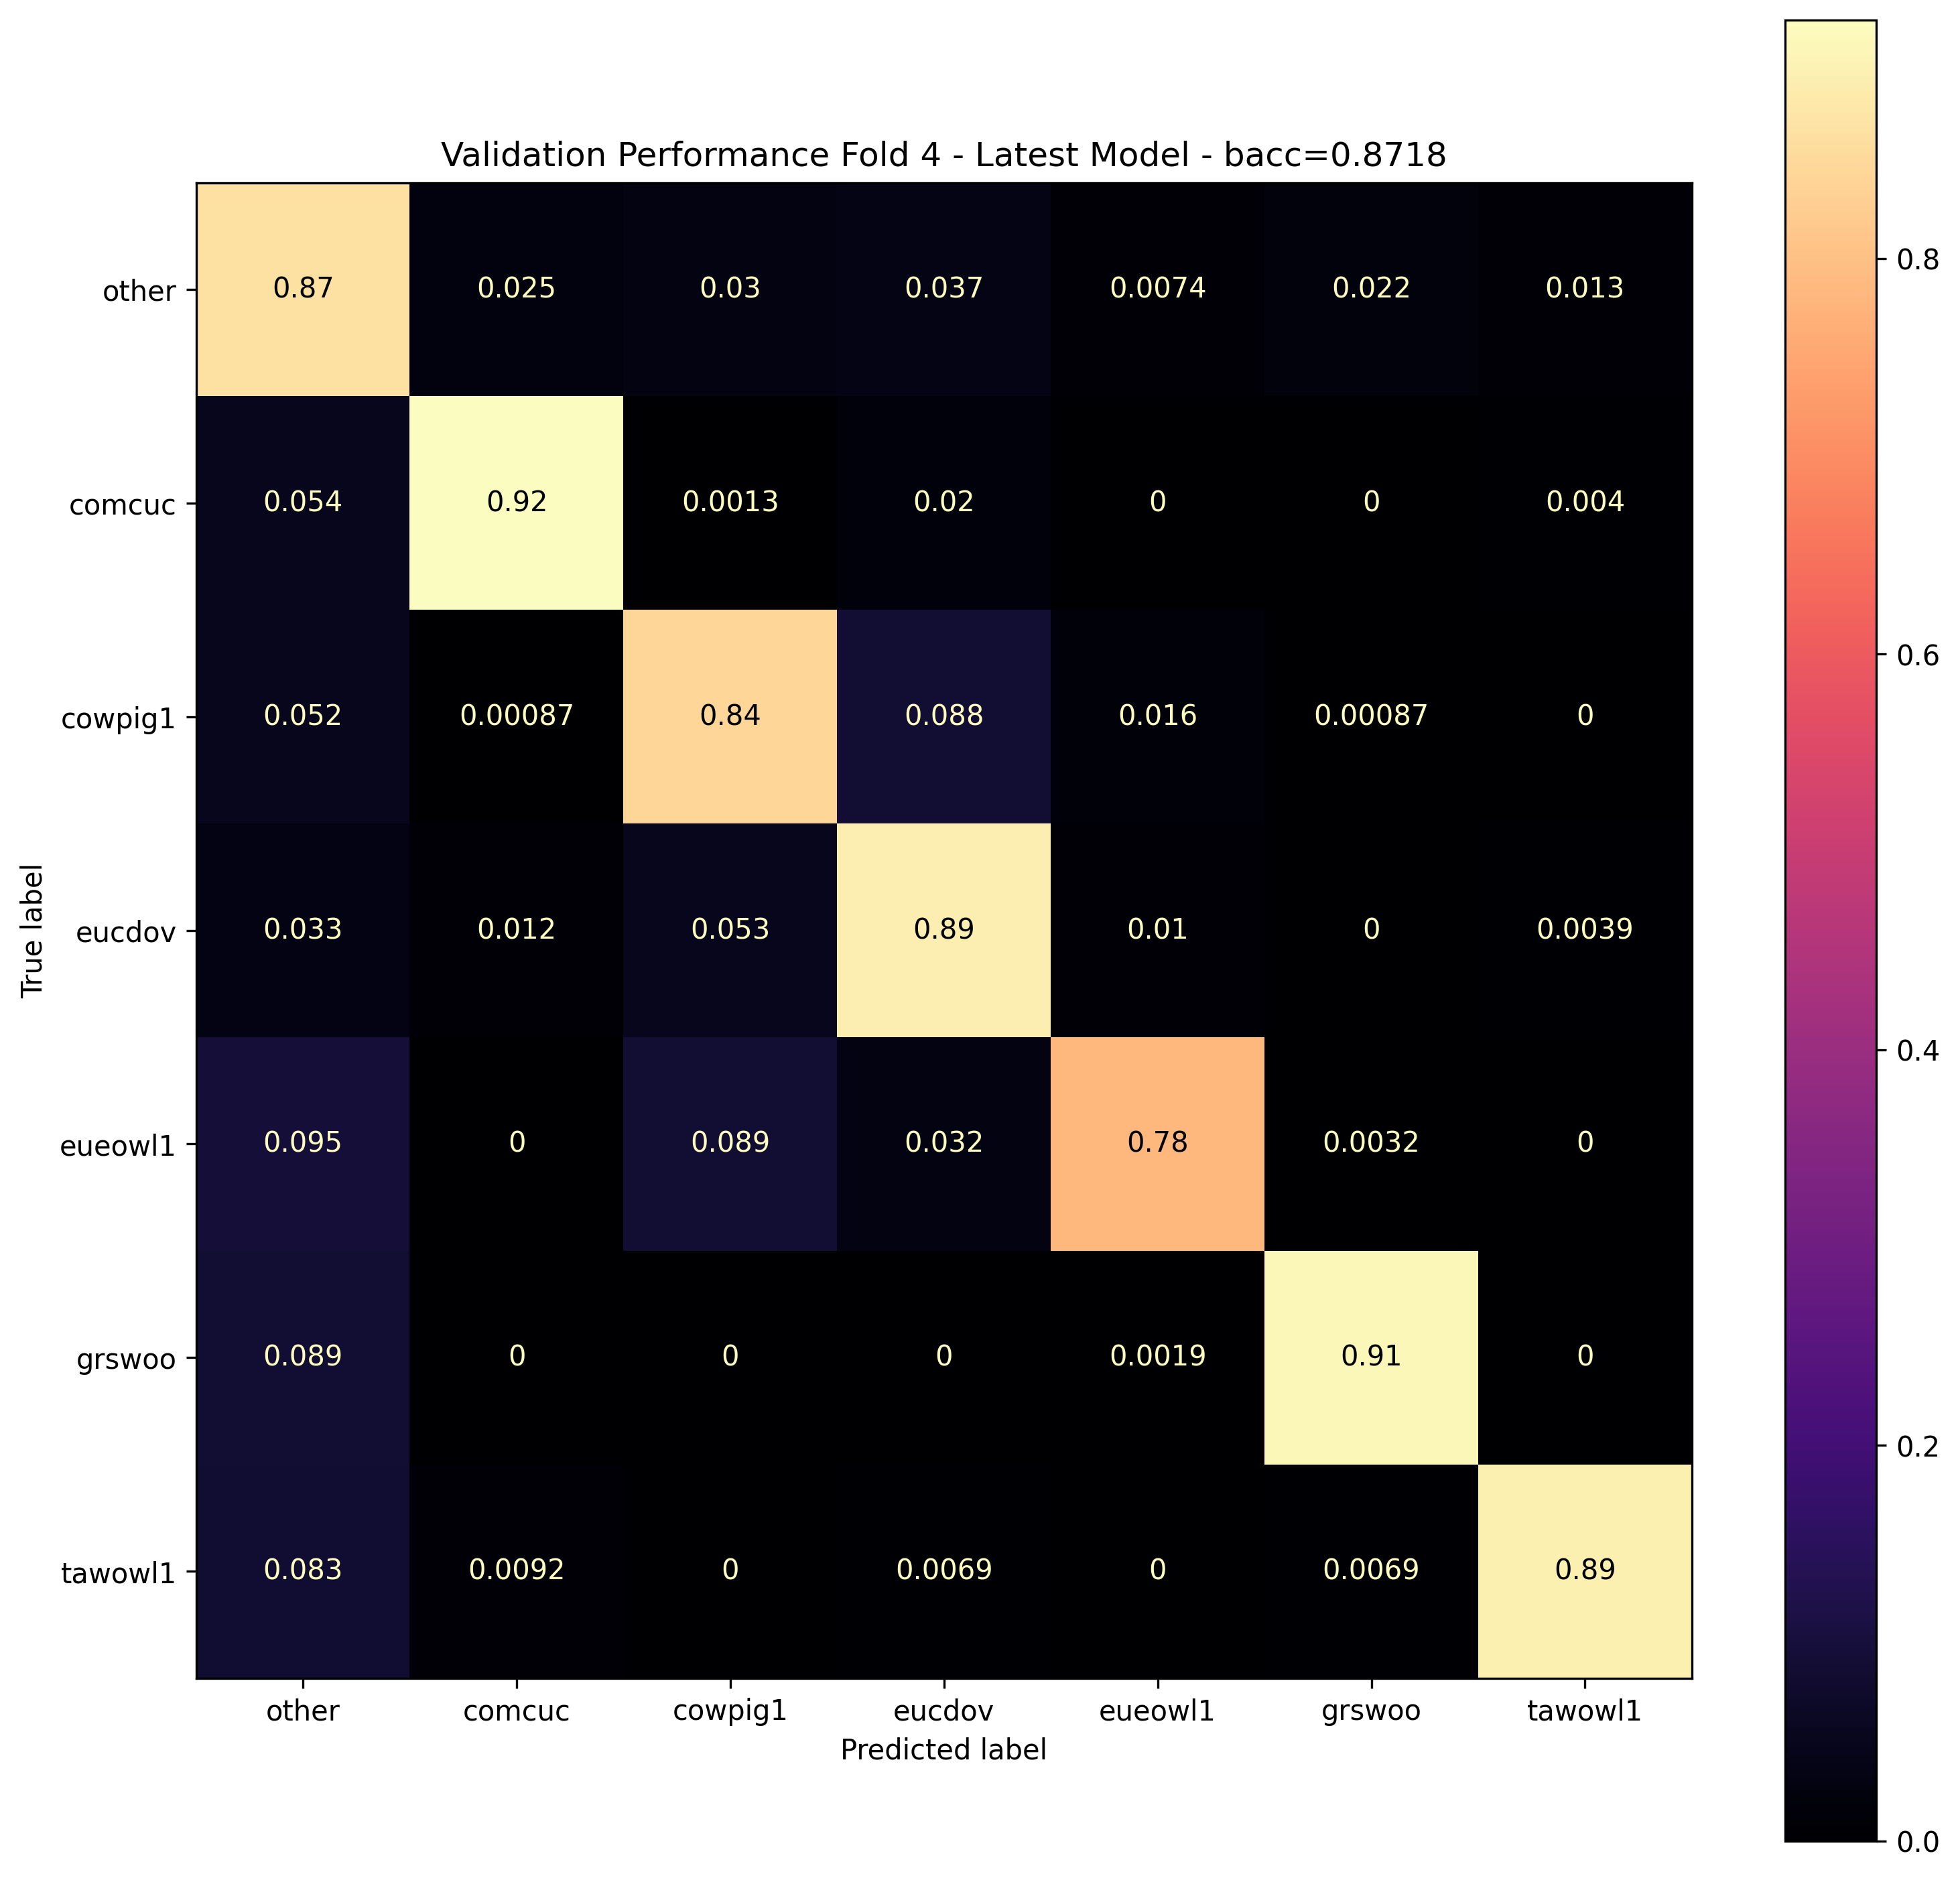

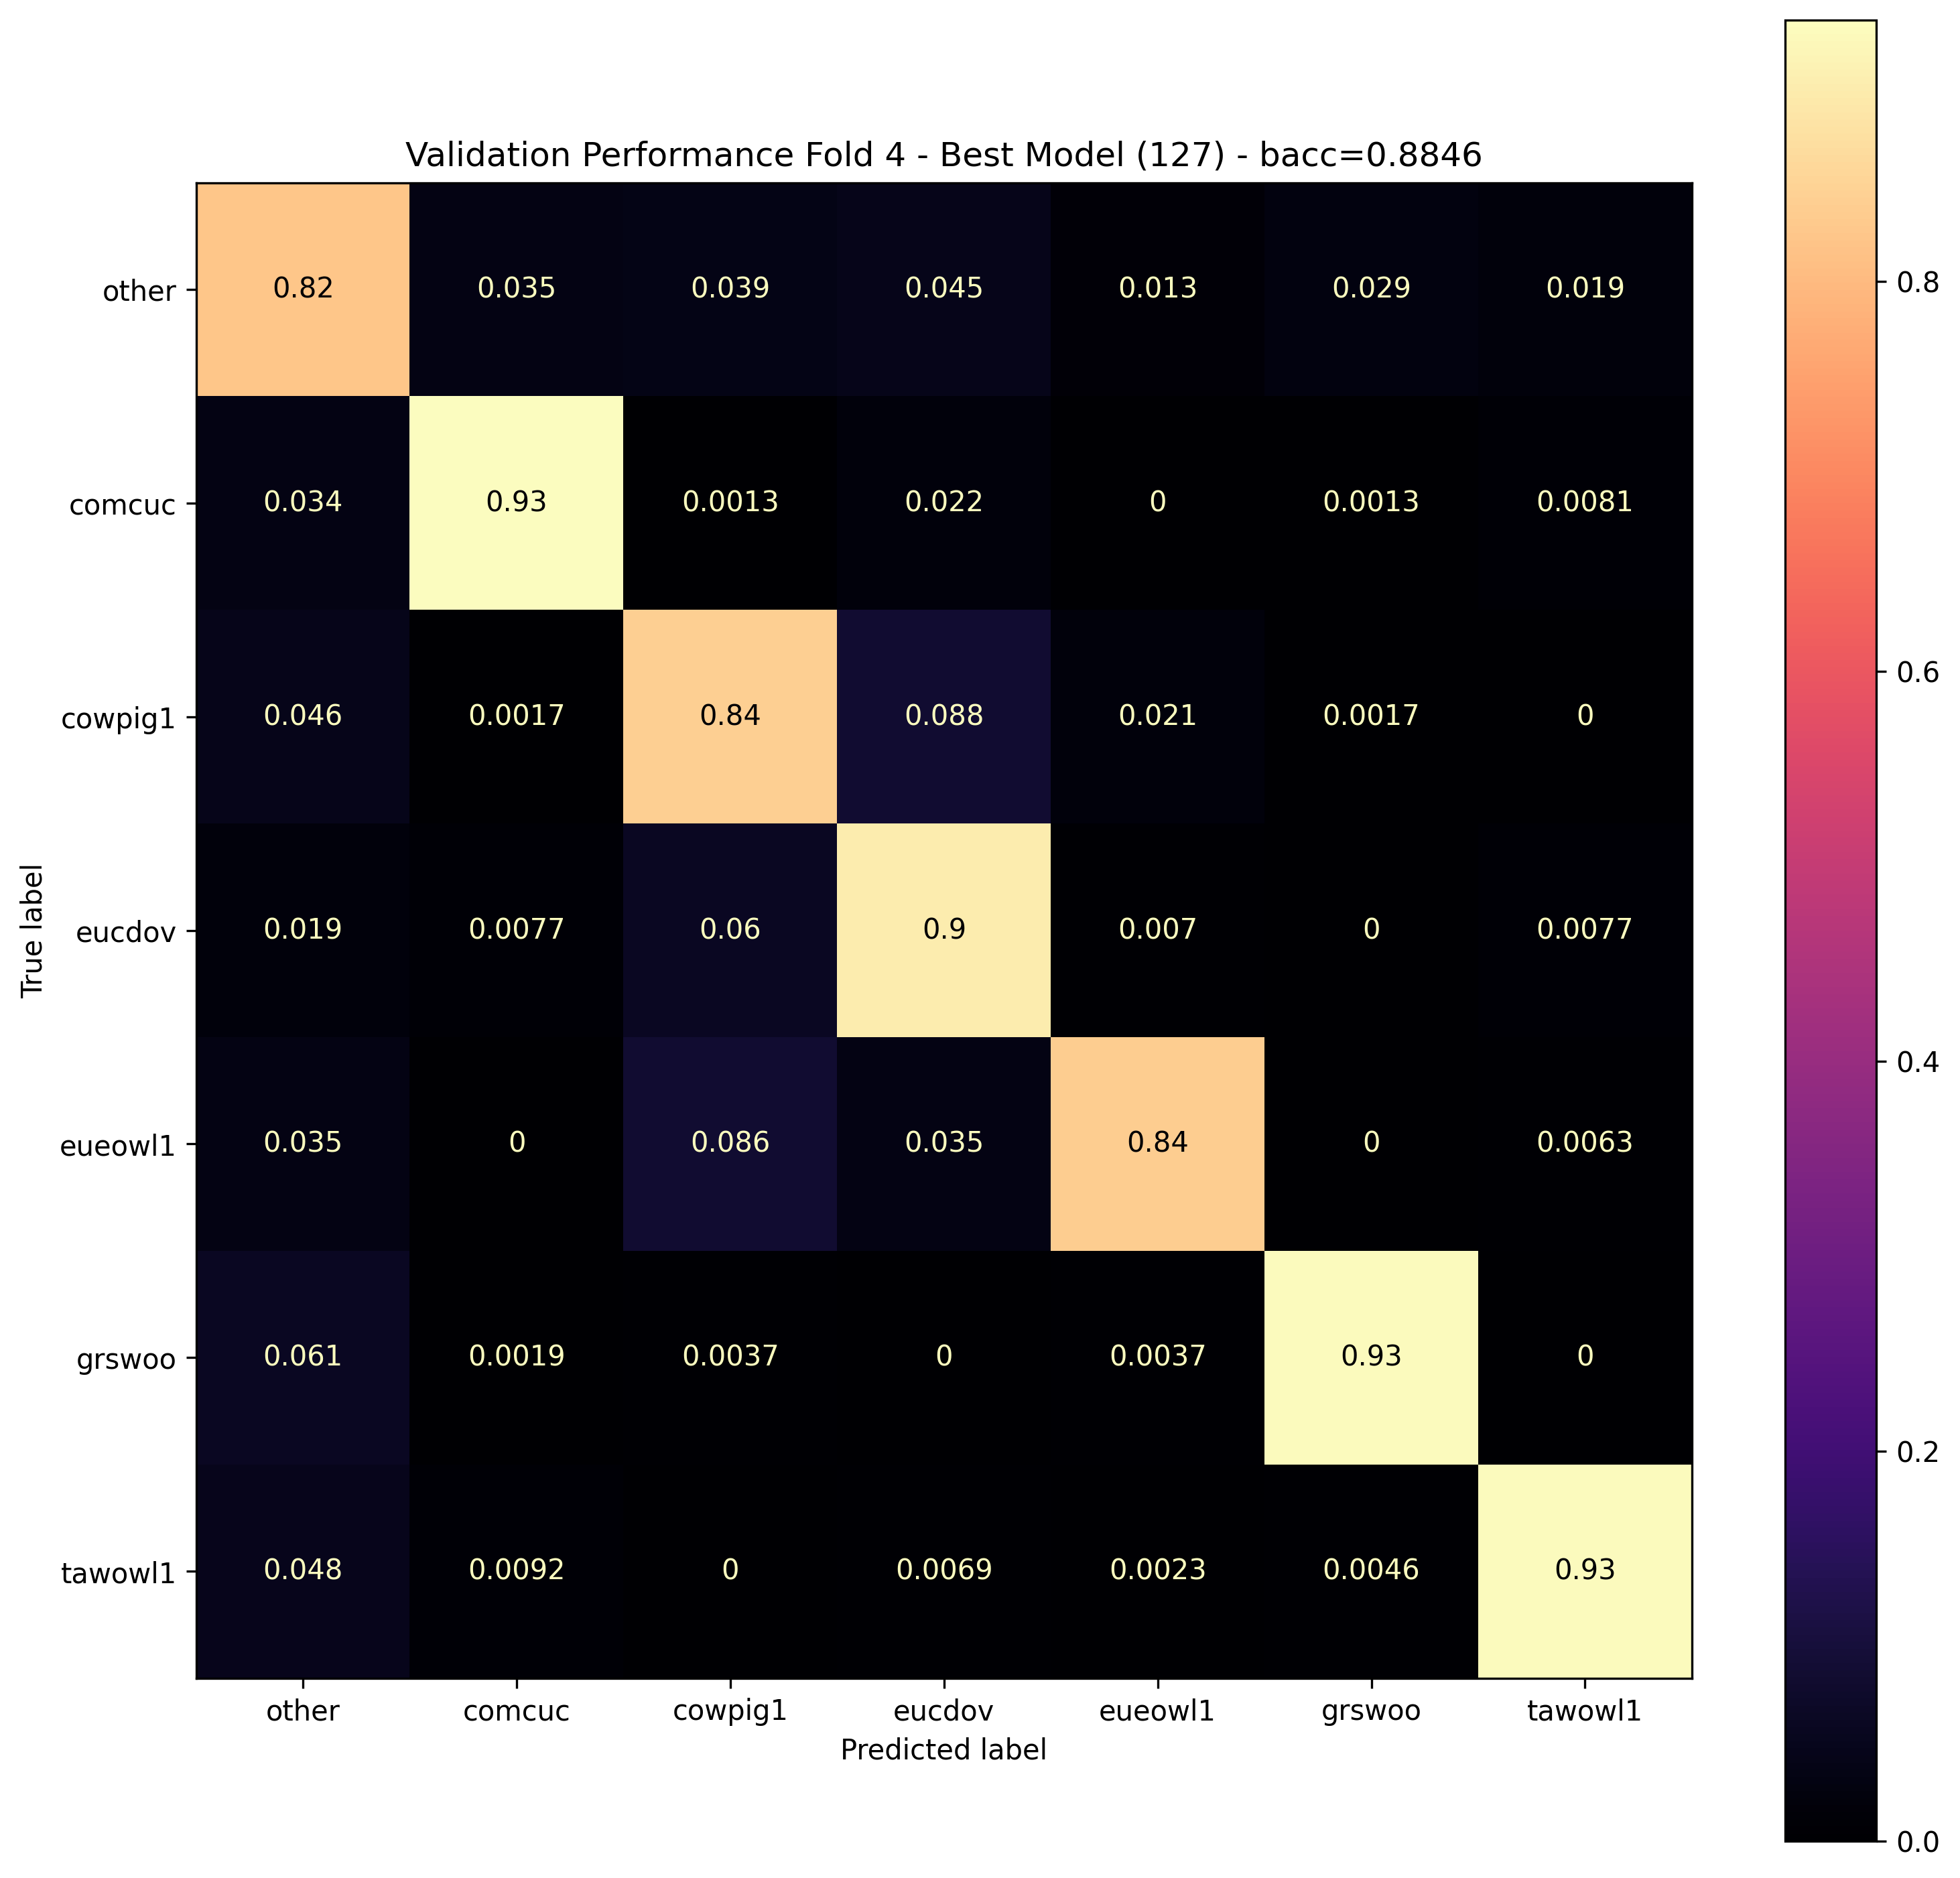

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-4-best train-bacc=0.9538 eval-bacc=0.8846"
Executing CV for fold 5
Training fold 5
Training AttentionClassifier with 62523 parameters
train label counts = [74768, 5033, 7810, 7102, 2089, 4491, 3707]
loss weights = [0.74, 14.86, 6.38, 10.53, 35.79, 16.65, 20.17]
eval label counts = [10590, 800, 1144, 1096, 235, 620, 515]
eval loss weights = [0.74, 13.24, 6.17, 9.66, 45.06, 17.08, 20.56]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000205, num_samples = 105000, num_correct =  4962, acc = 0.047257, bacc = 0.143921
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000270, num_samples = 15000, num_correct =   800, acc = 0.053333, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000204, num_samples = 105000, num_correct =  5033, acc = 0.047933, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000273, num_samples = 15000, num_correct =   800

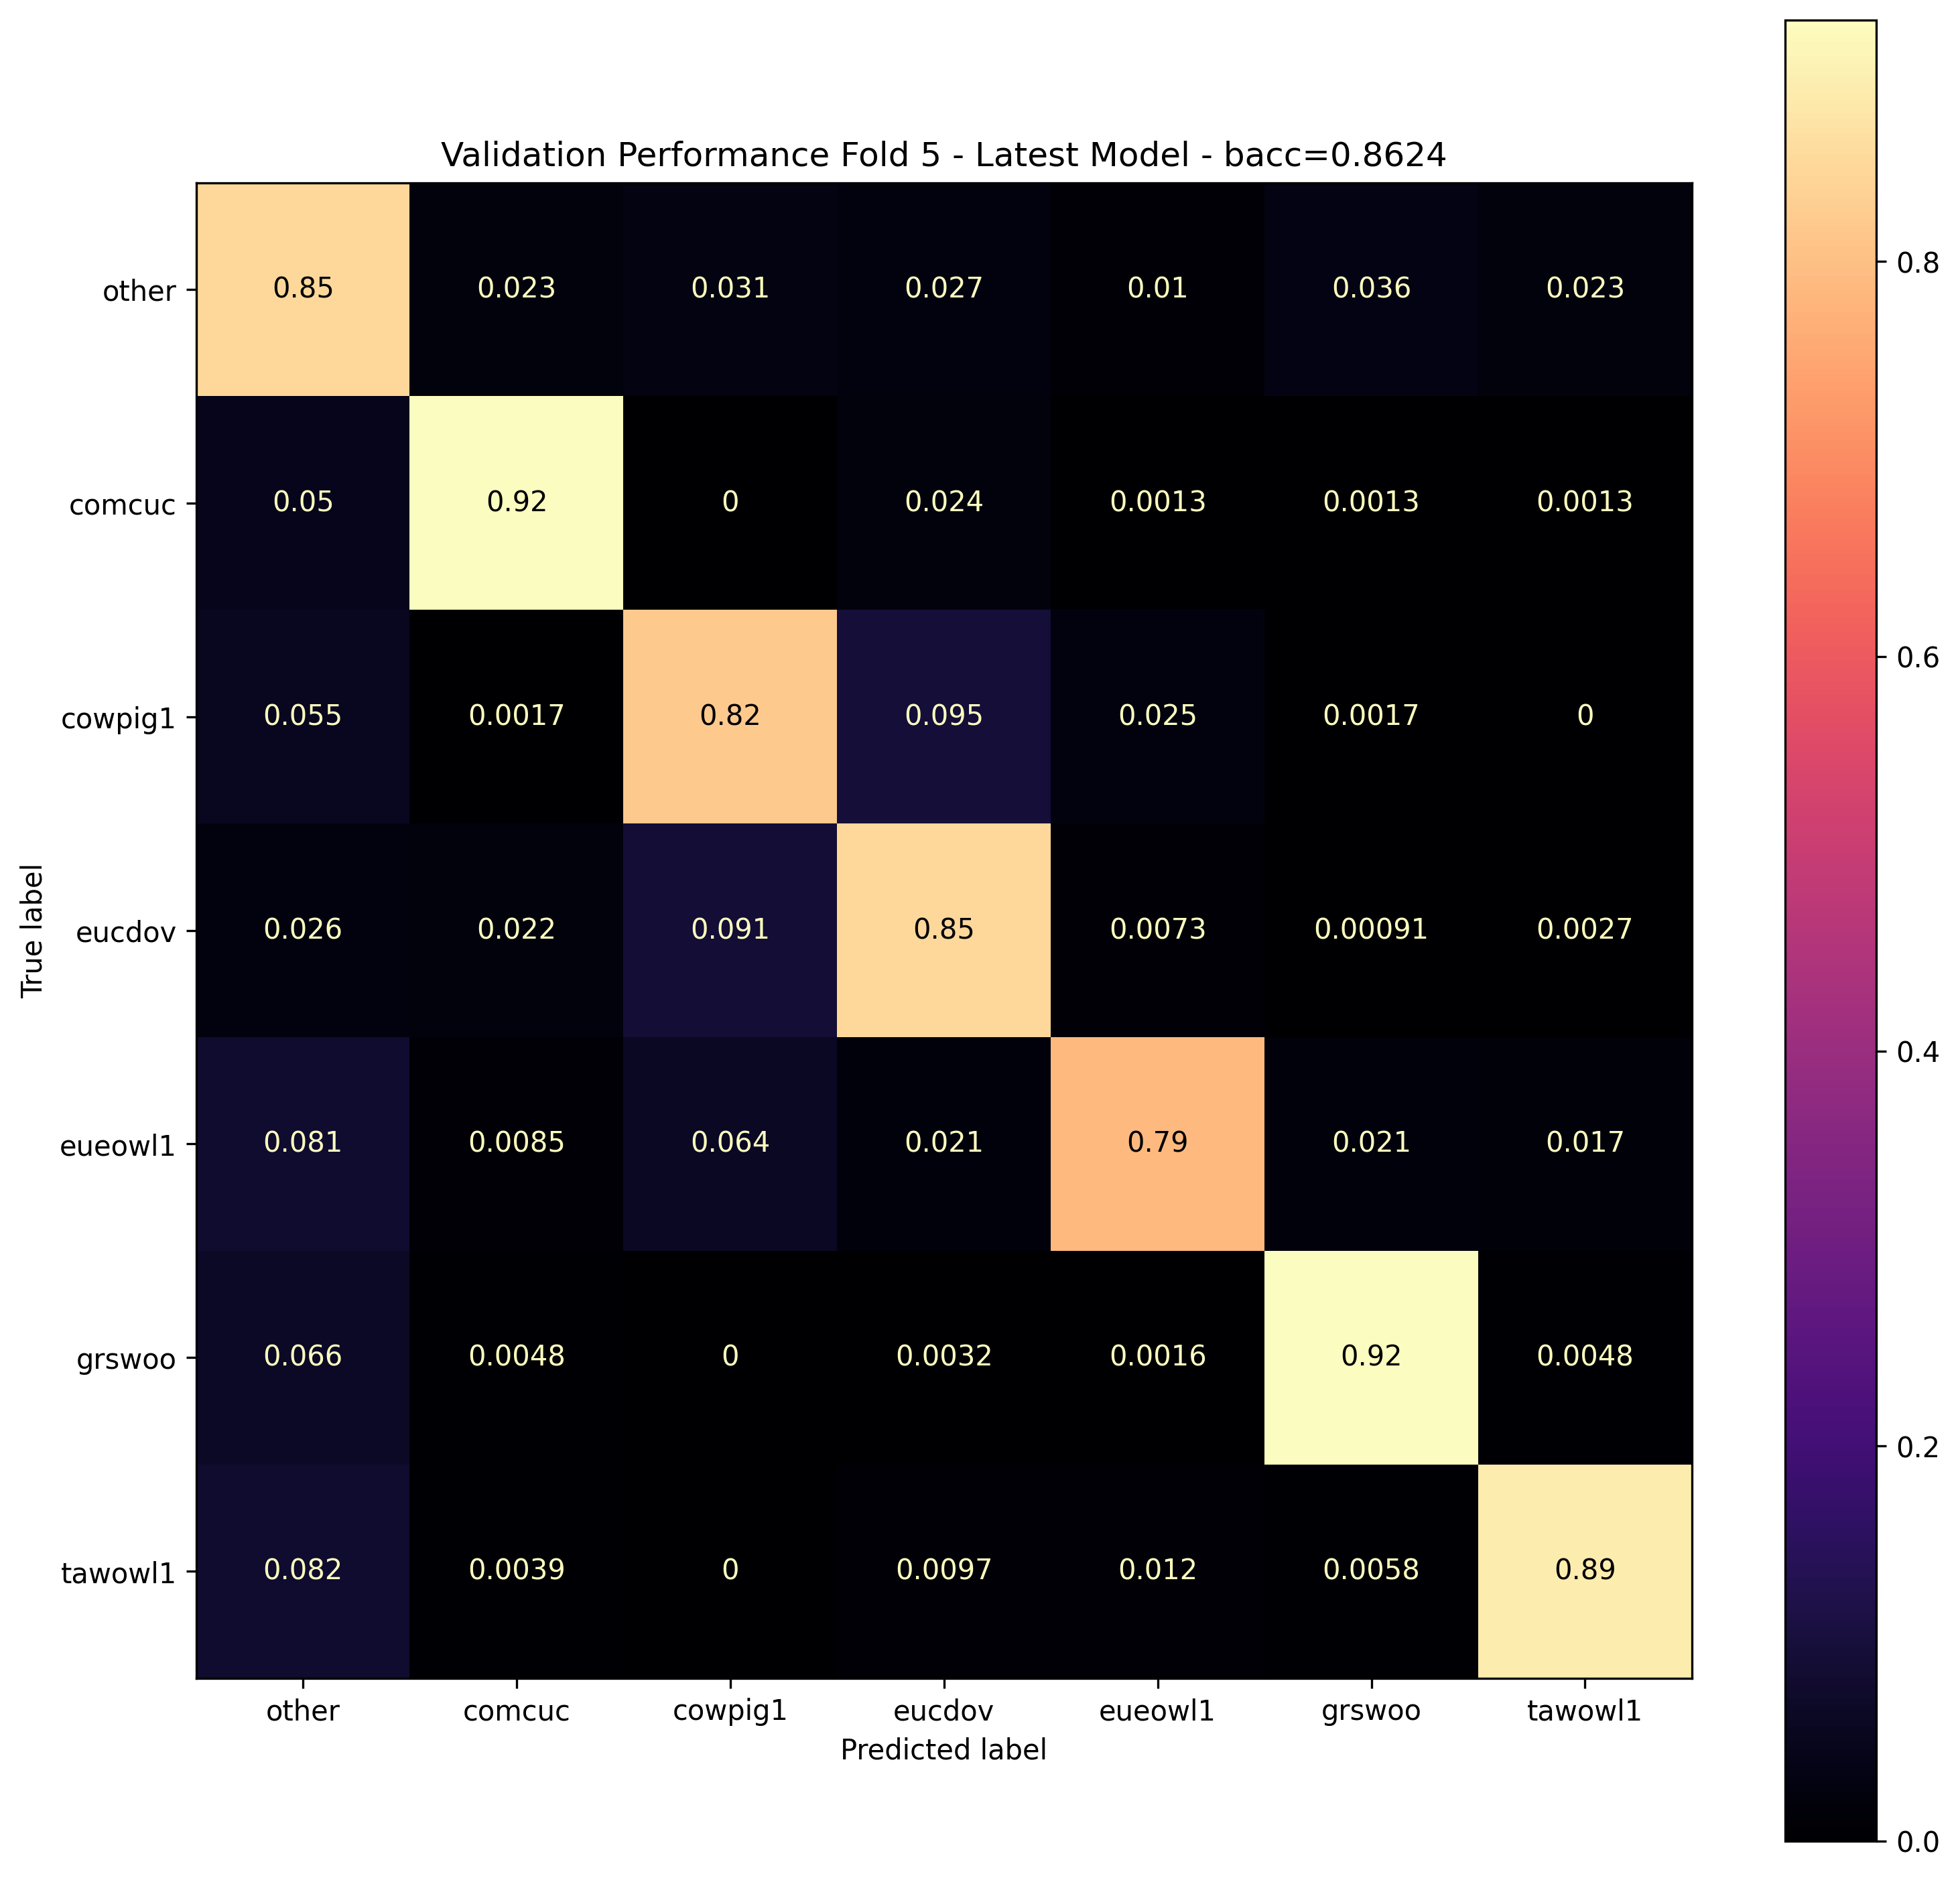

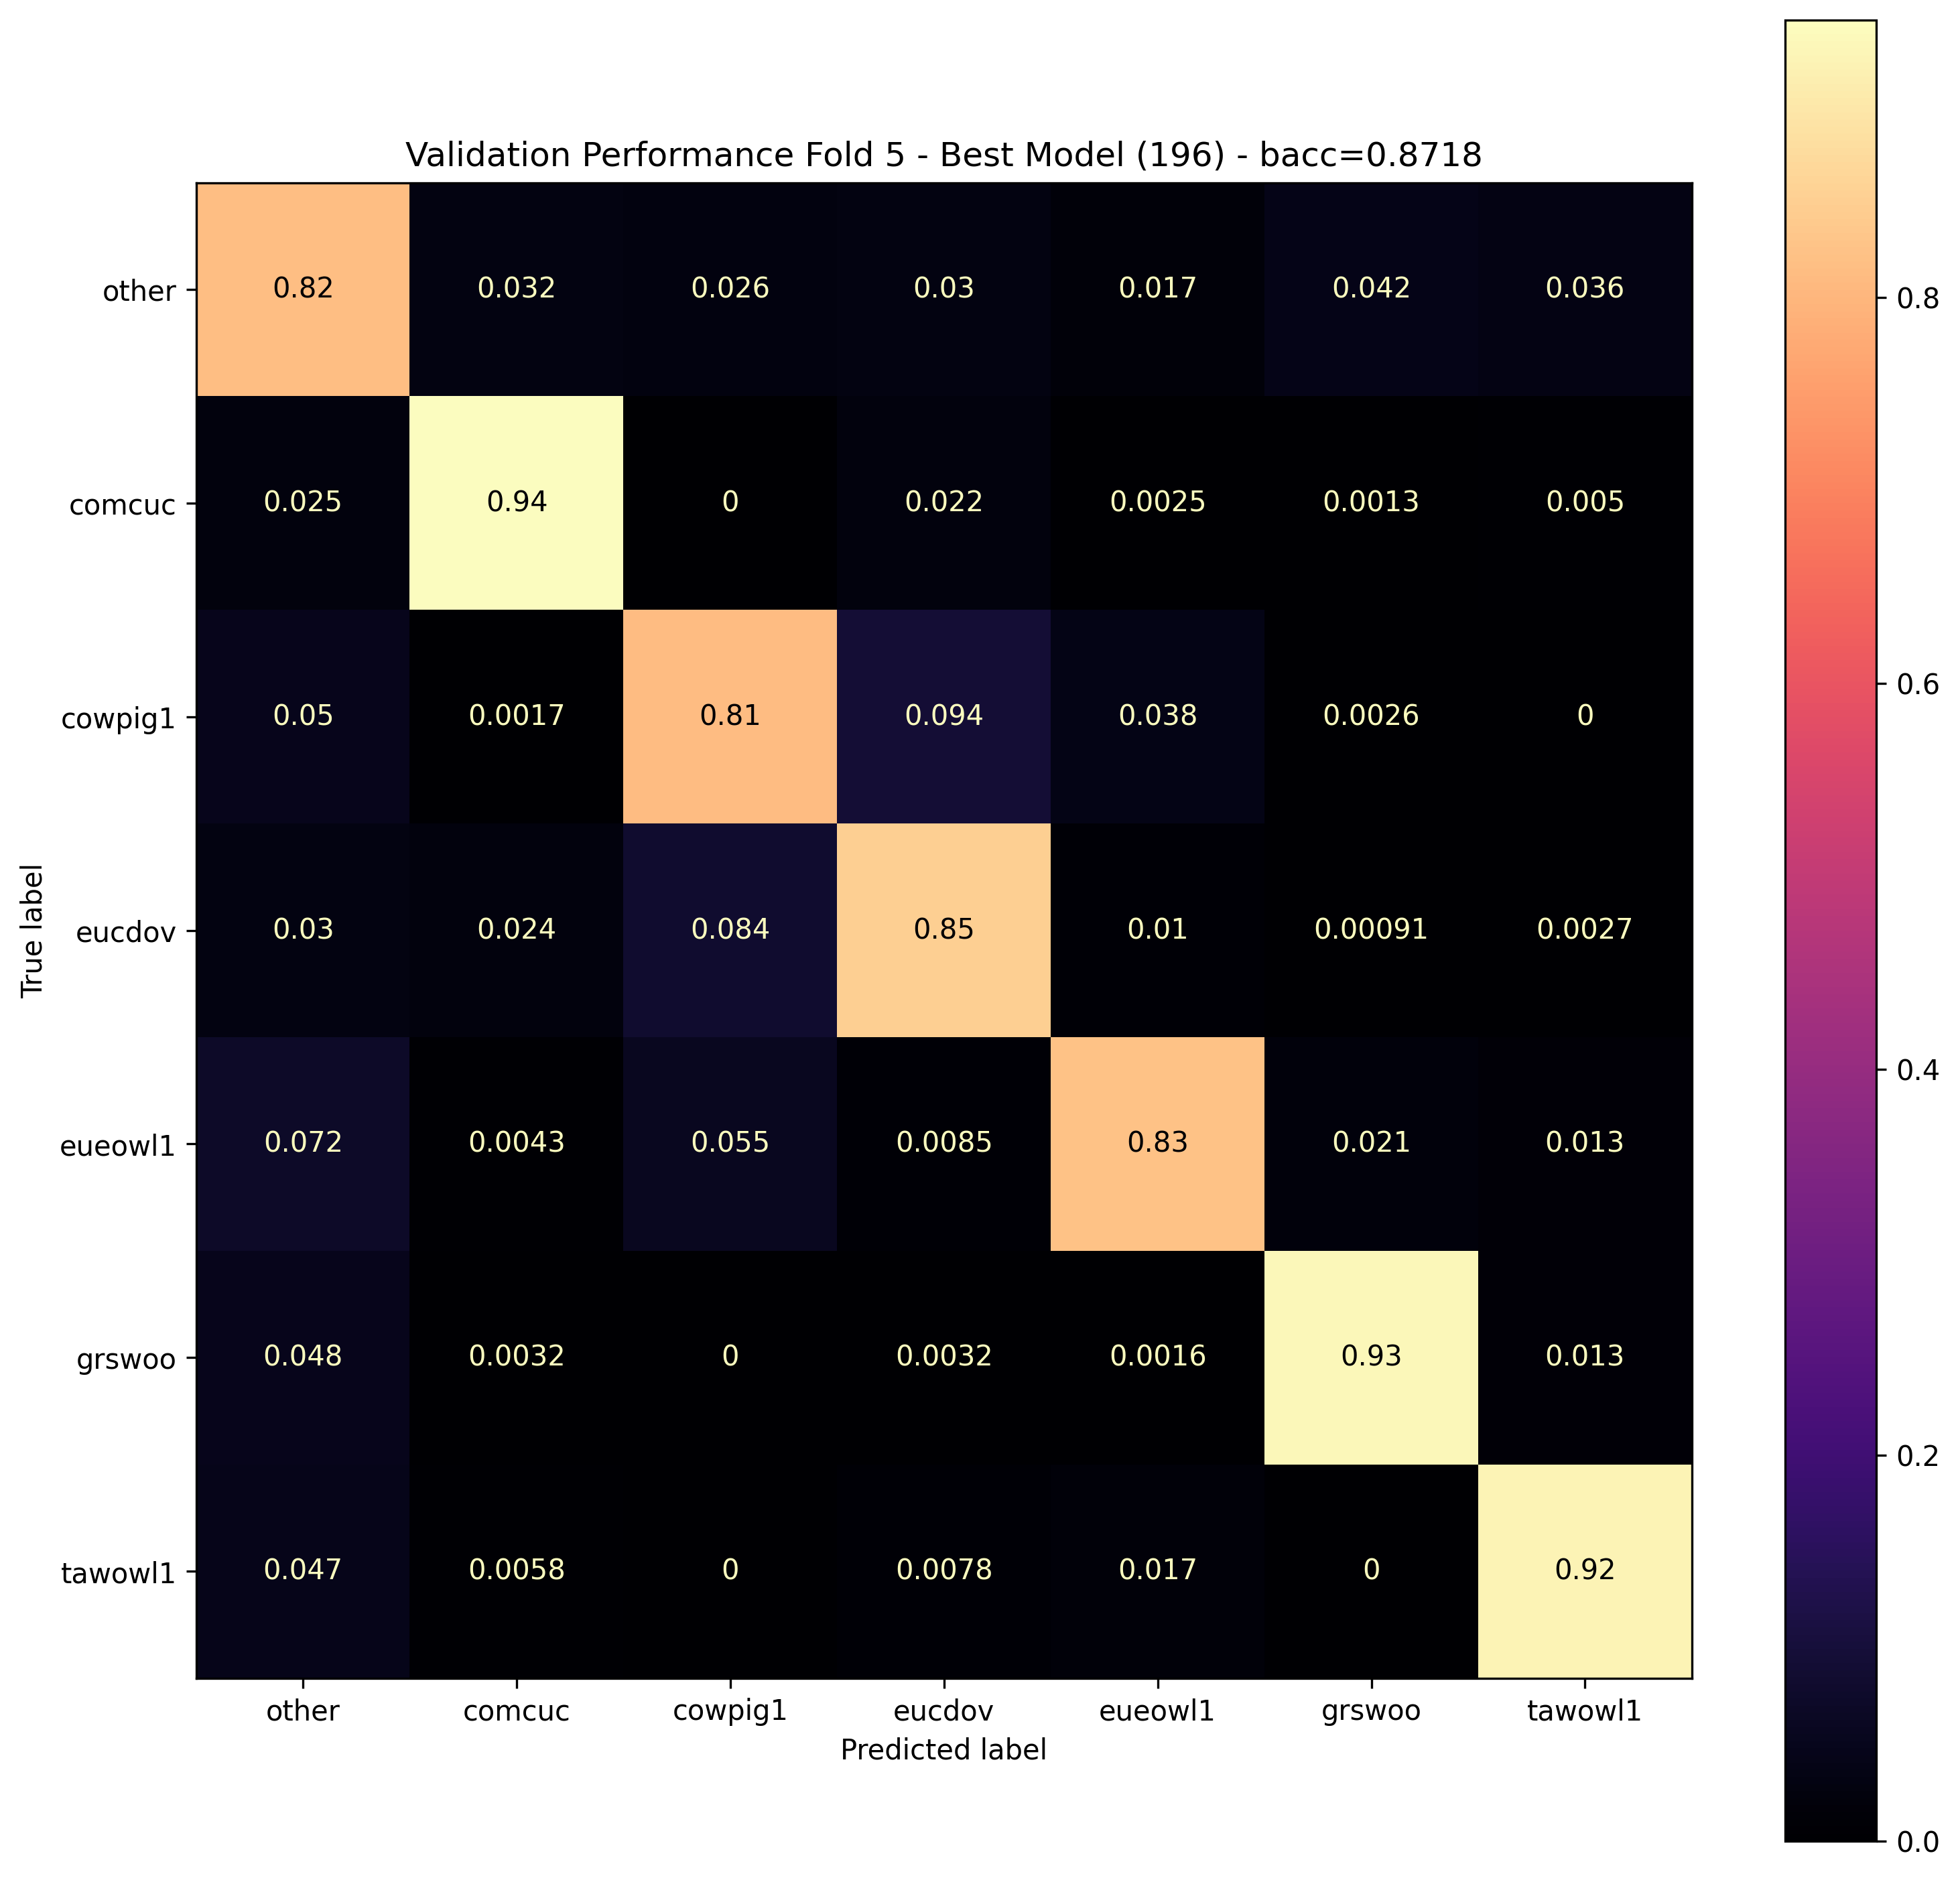

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-5-best train-bacc=0.9619 eval-bacc=0.8718"
Executing CV for fold 6
Training fold 6
Training AttentionClassifier with 62523 parameters
train label counts = [74712, 4979, 7898, 7221, 2044, 4413, 3733]
loss weights = [0.74, 15.01, 6.31, 10.35, 36.55, 16.93, 20.01]
eval label counts = [10646, 854, 1056, 977, 280, 698, 489]
eval loss weights = [0.74, 12.47, 6.72, 10.9, 38.02, 15.25, 21.77]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000205, num_samples = 105000, num_correct =  2681, acc = 0.025533, bacc = 0.143608
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000275, num_samples = 15000, num_correct =   280, acc = 0.018667, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000204, num_samples = 105000, num_correct =  2044, acc = 0.019467, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000286, num_samples = 15000, num_correct =   280,

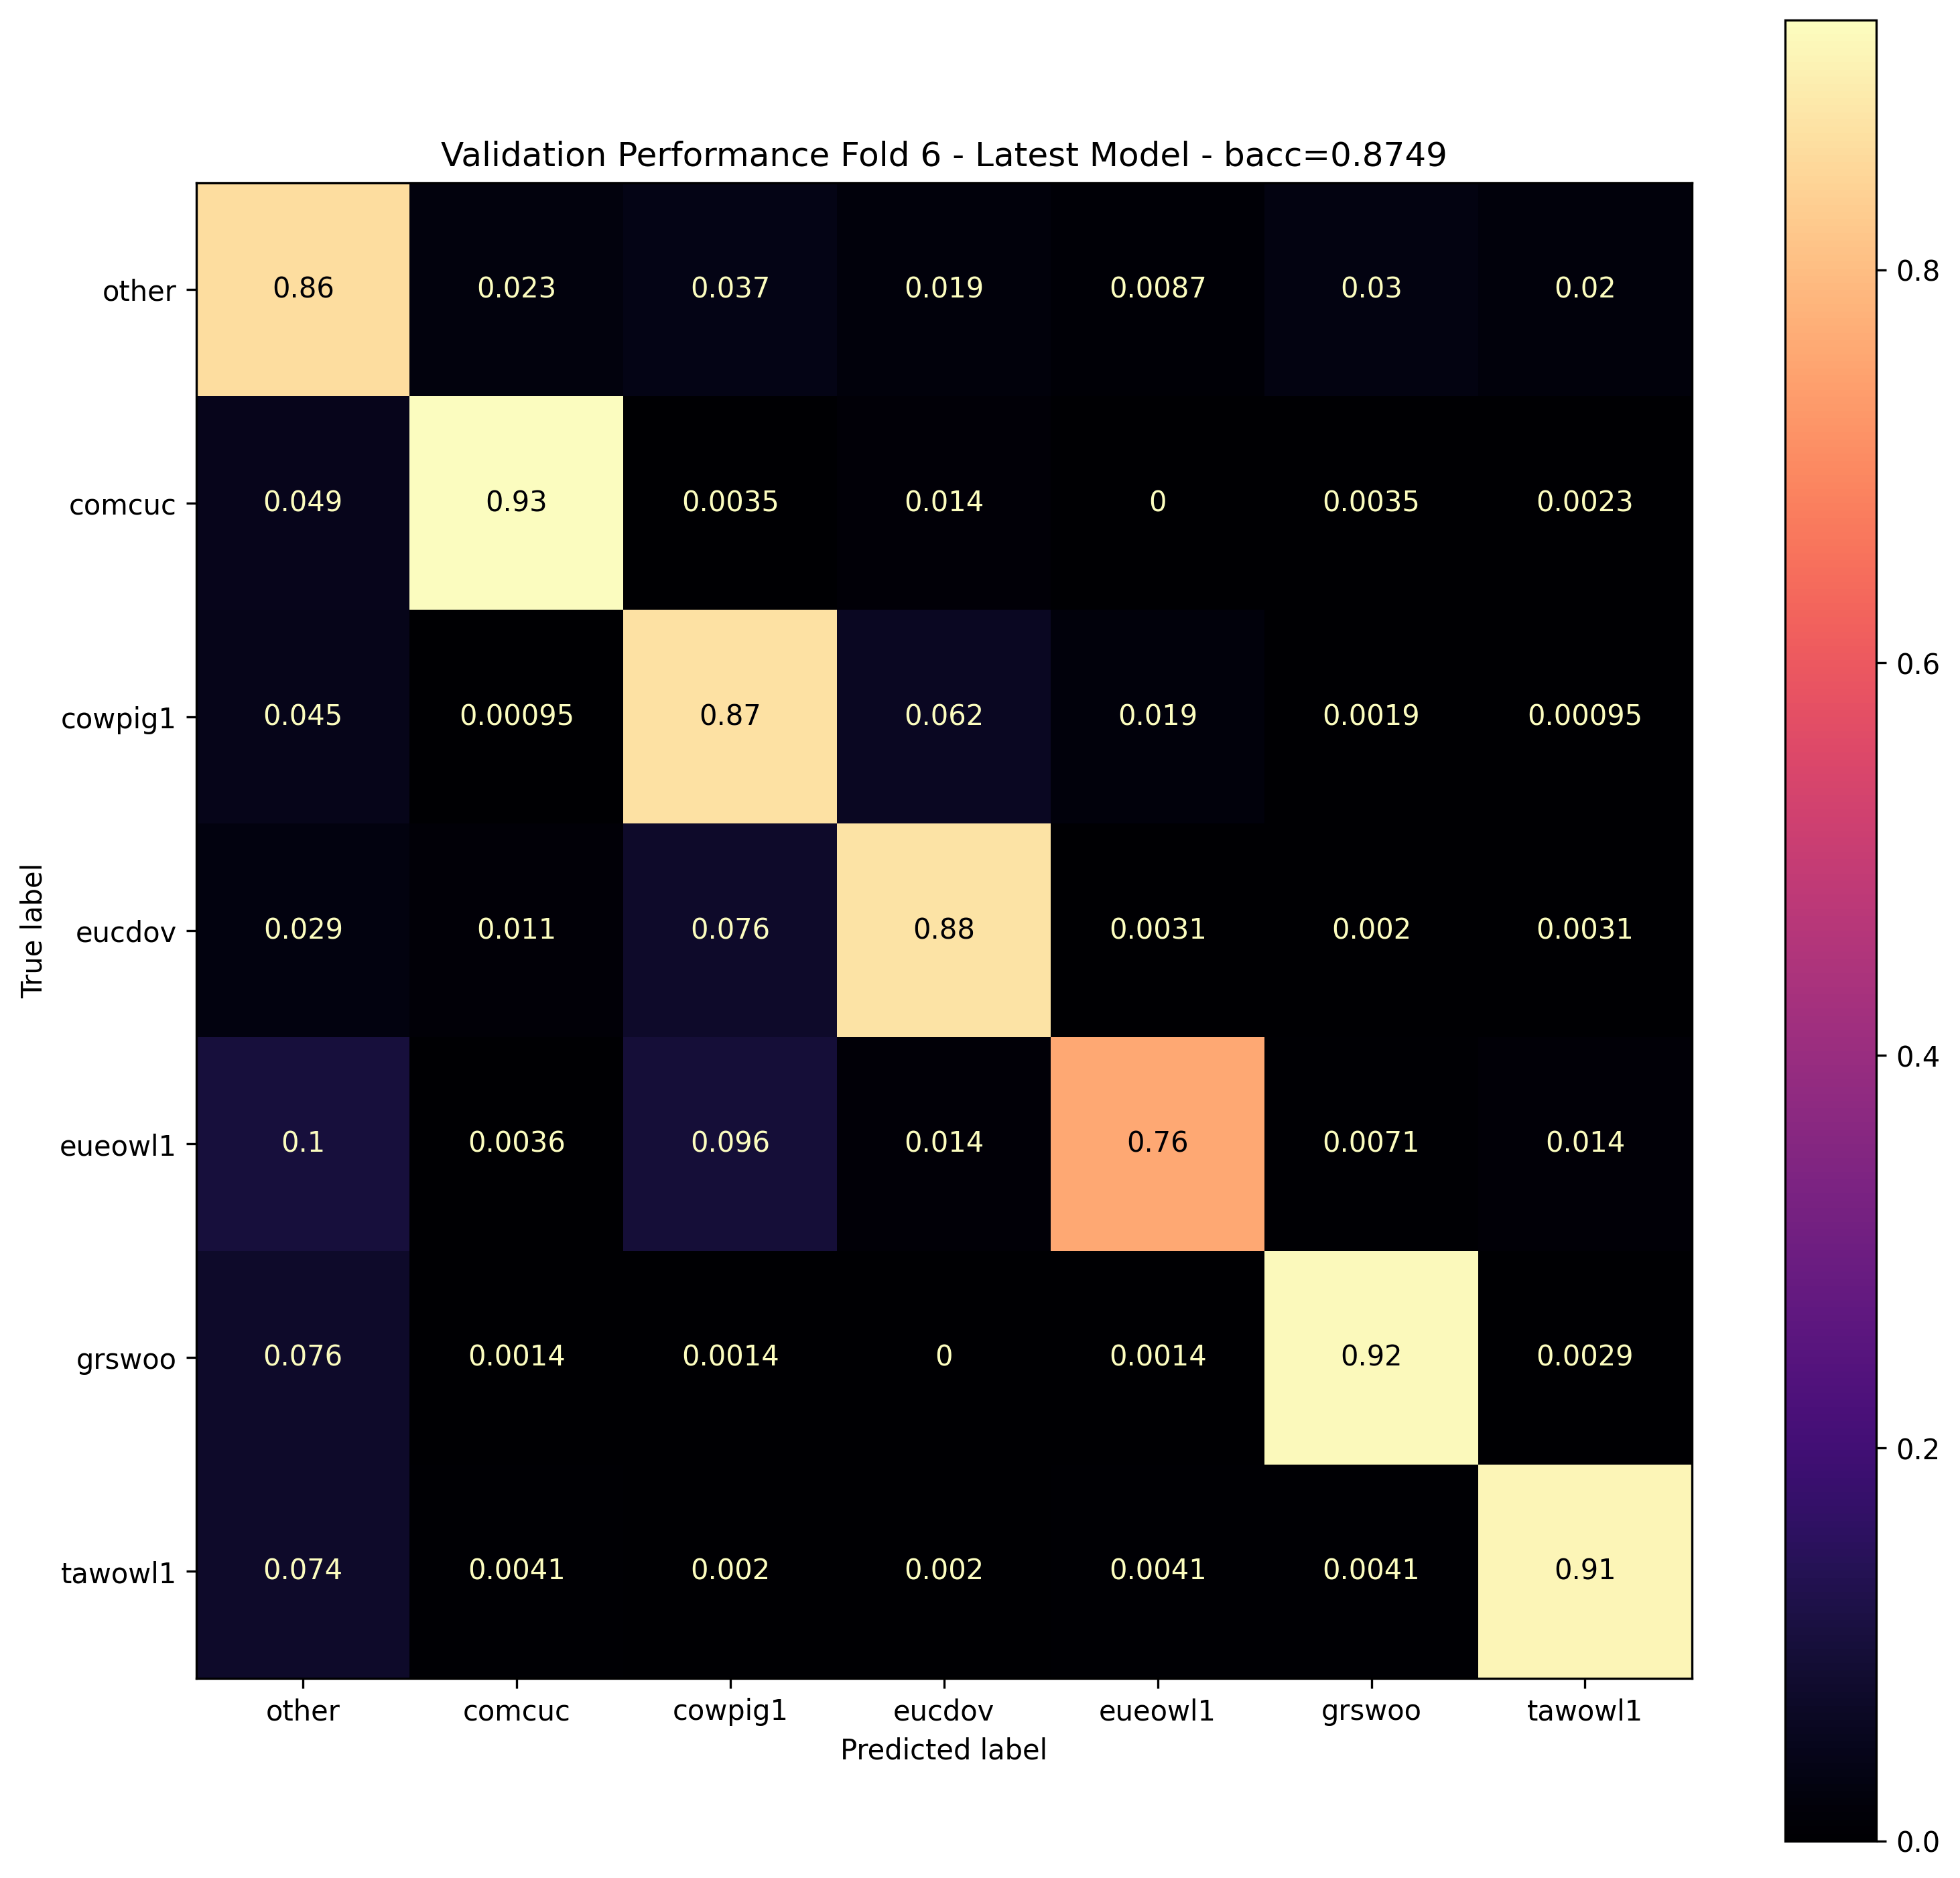

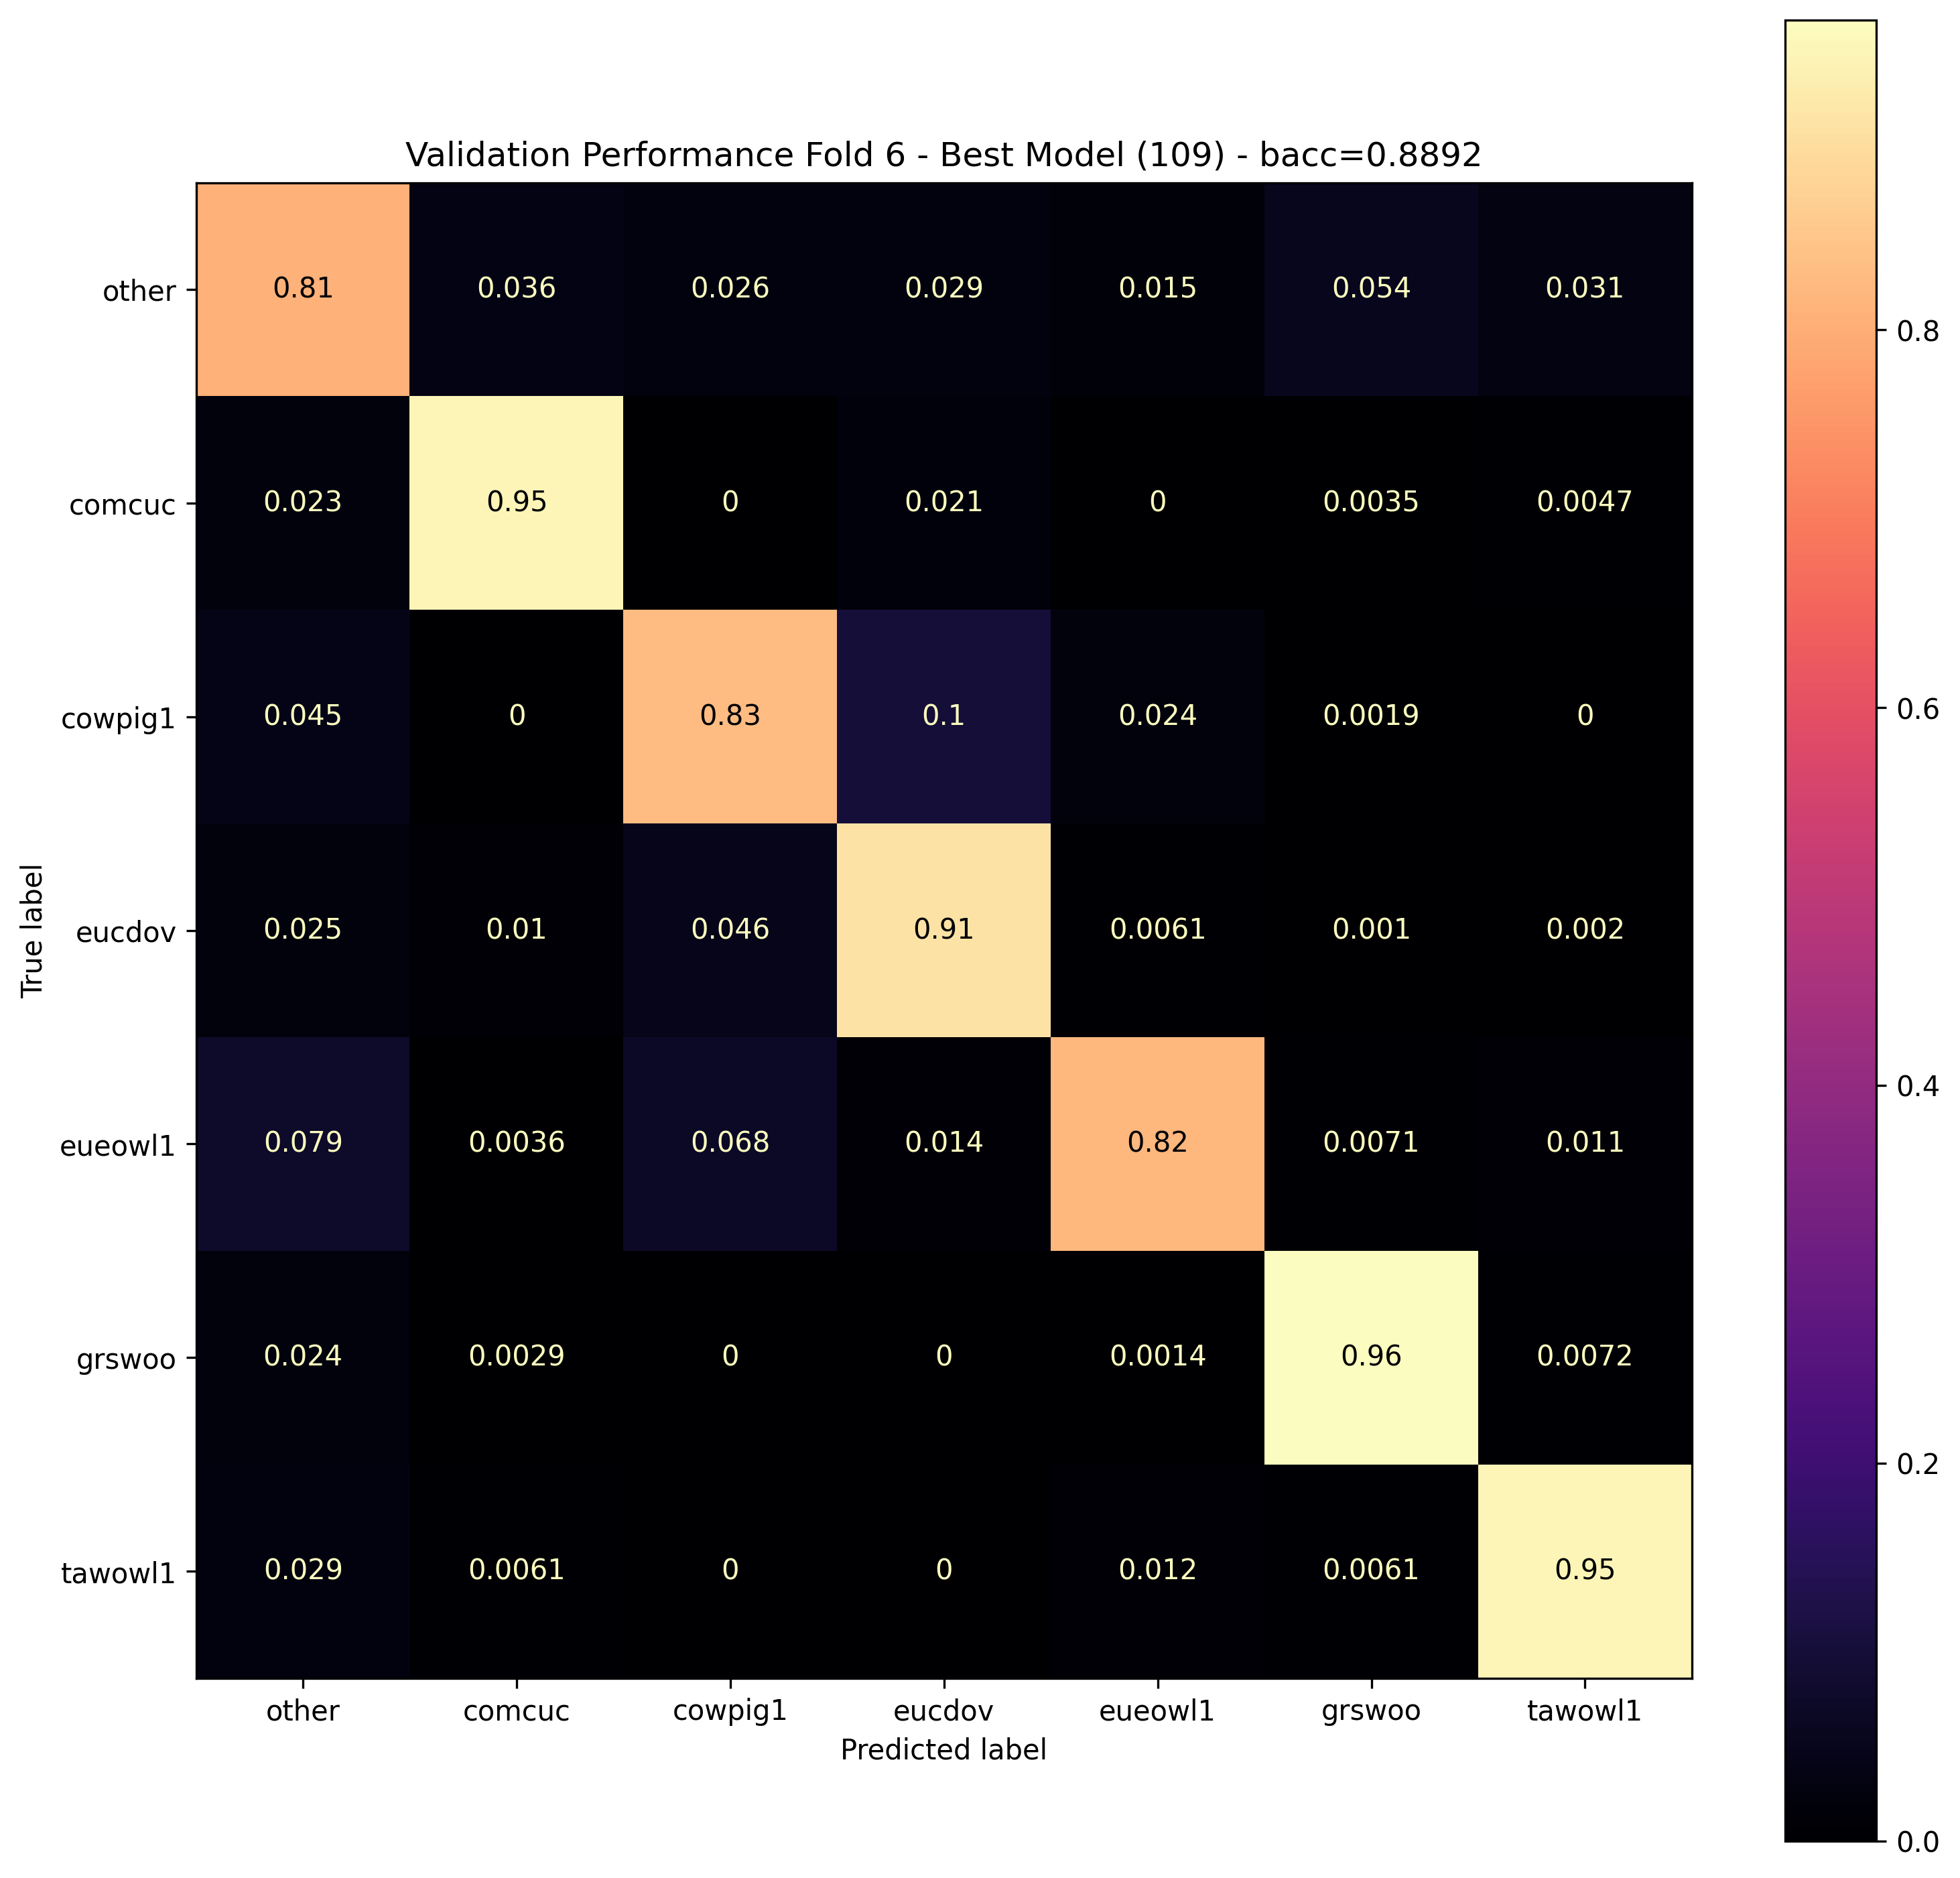

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-6-best train-bacc=0.9490 eval-bacc=0.8892"
Executing CV for fold 7
Training fold 7
Training AttentionClassifier with 62523 parameters
train label counts = [74658, 5710, 7433, 7450, 2050, 4242, 3457]
loss weights = [0.74, 13.07, 6.7, 10.02, 36.42, 17.6, 21.6]
eval label counts = [10700, 123, 1521, 748, 274, 869, 765]
eval loss weights = [0.74, 86.99, 4.69, 14.3, 39.05, 12.31, 13.99]
Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000203, num_samples = 105000, num_correct =  5398, acc = 0.051410, bacc = 0.141848
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000280, num_samples = 15000, num_correct =   748, acc = 0.049867, bacc = 0.142857
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000203, num_samples = 105000, num_correct =  7450, acc = 0.070952, bacc = 0.142857
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000280, num_samples = 15000, num_correct =   748, ac

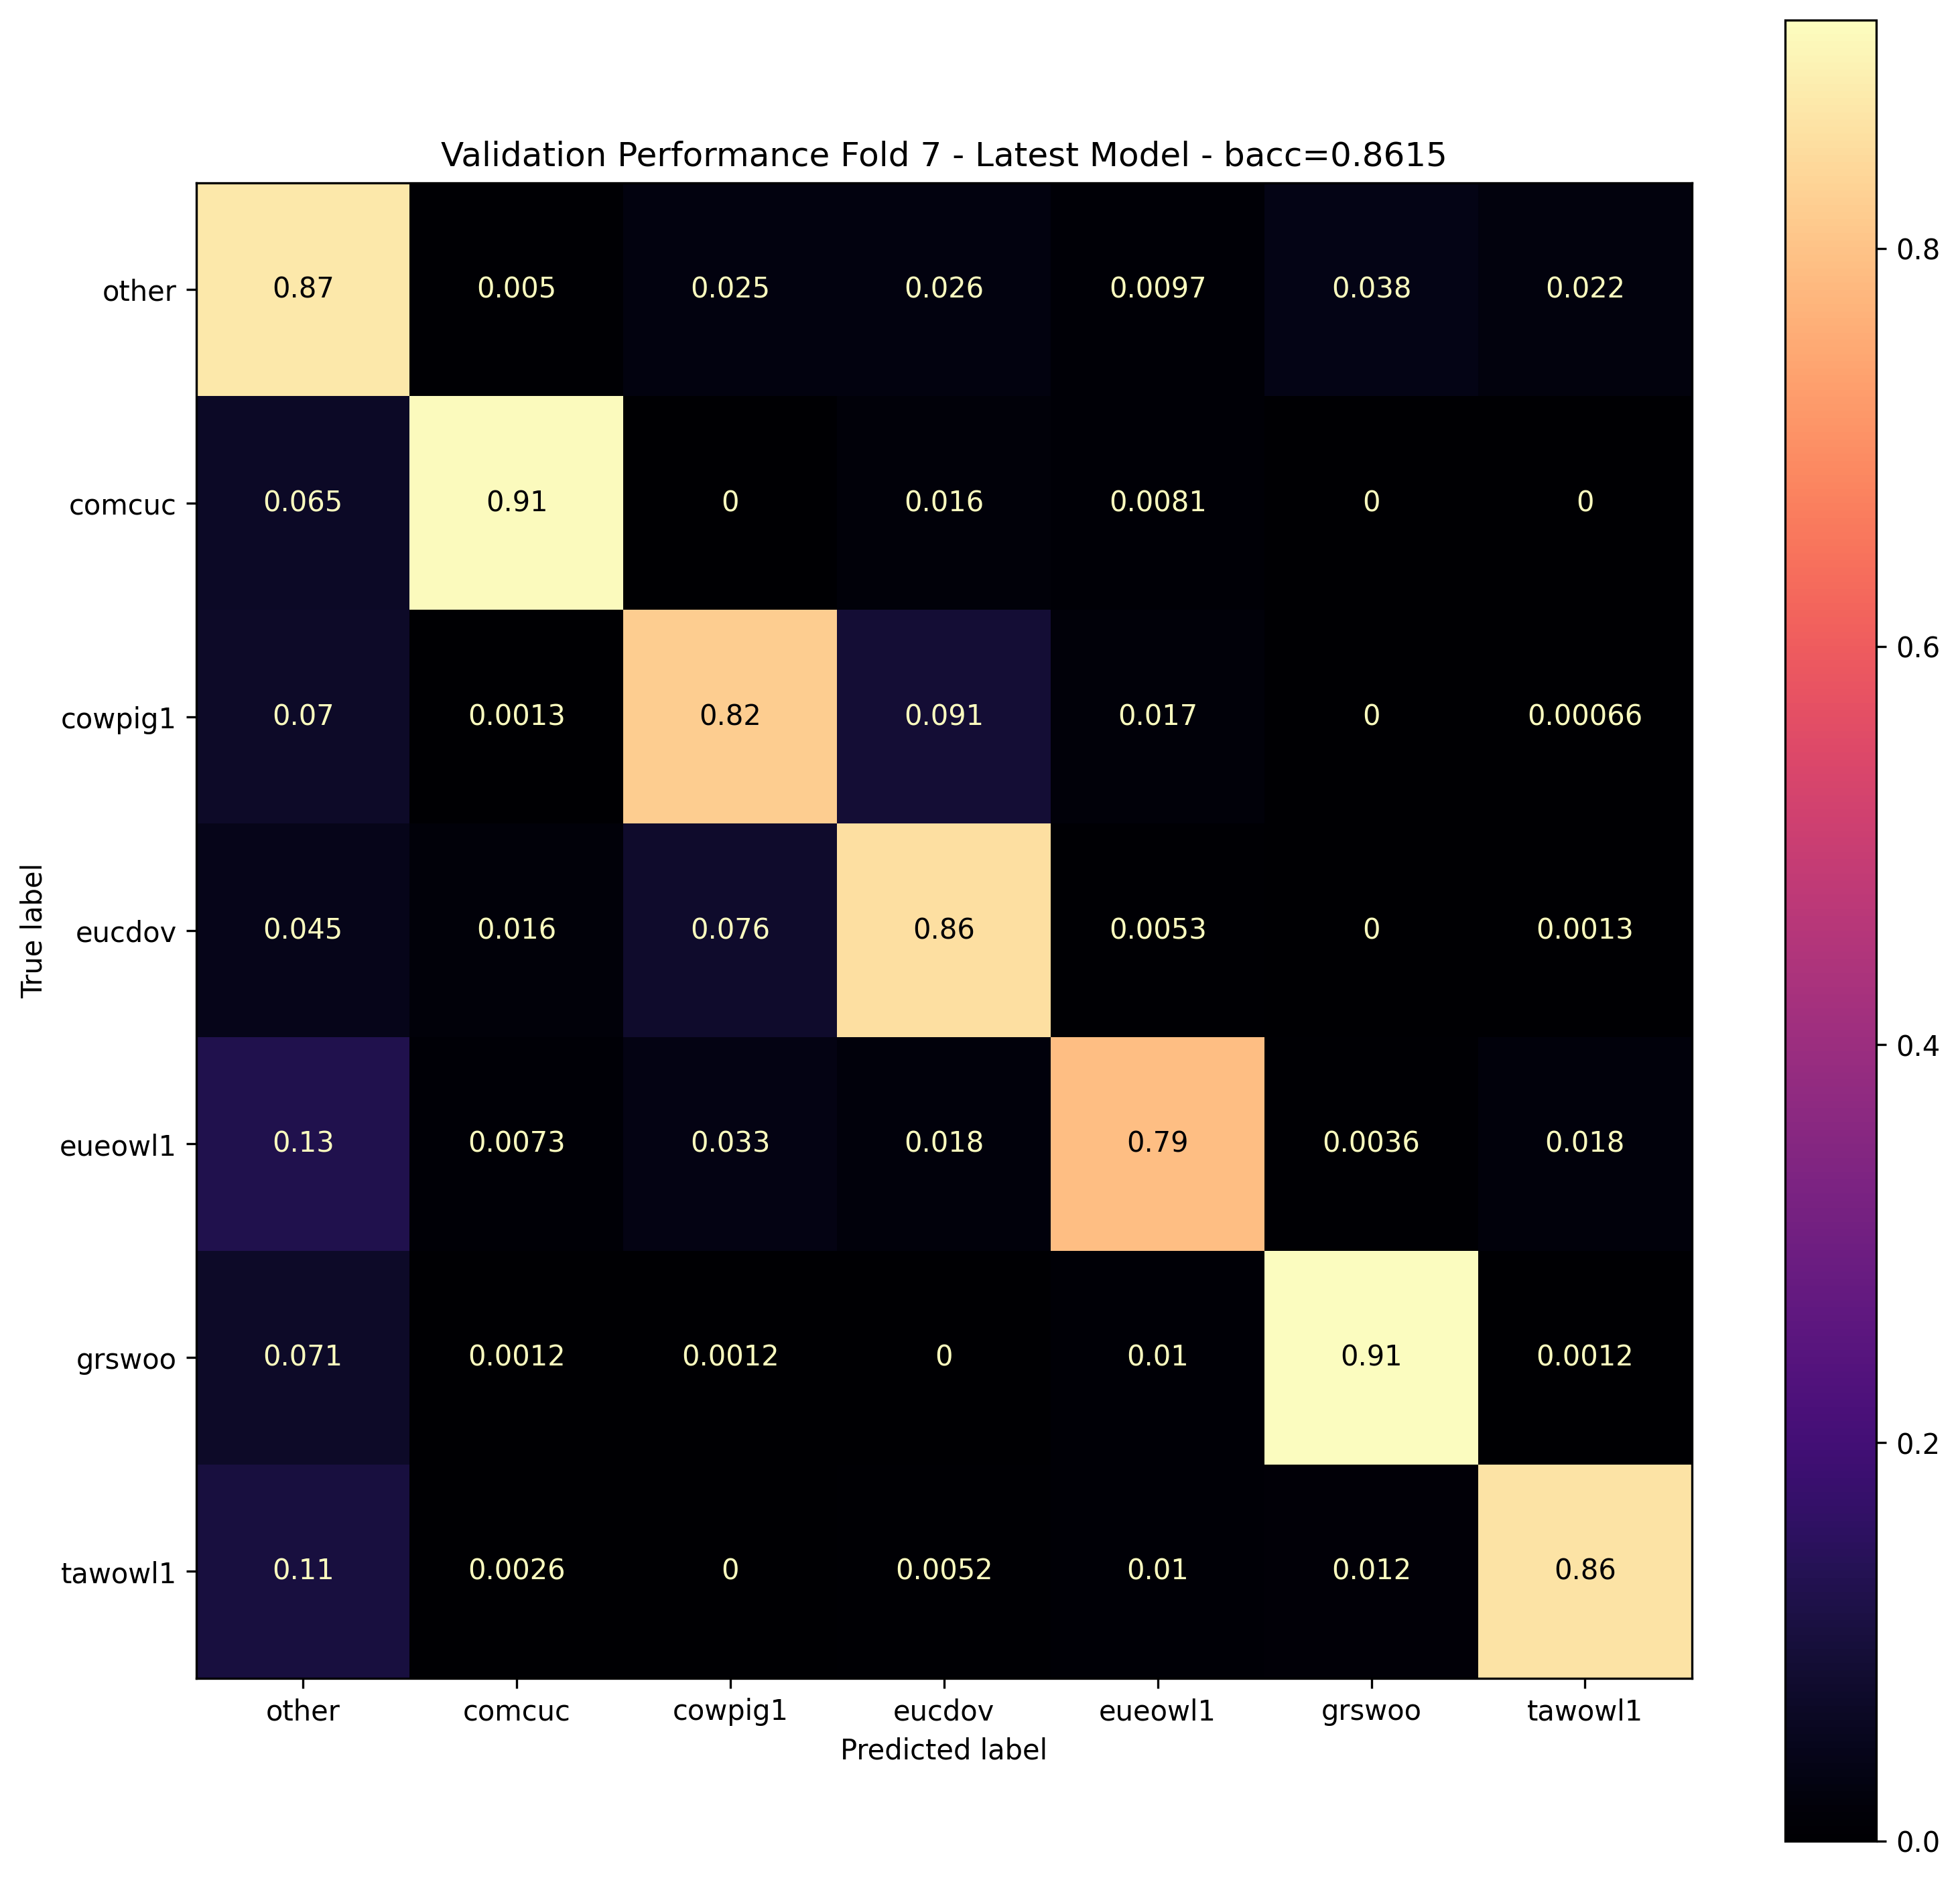

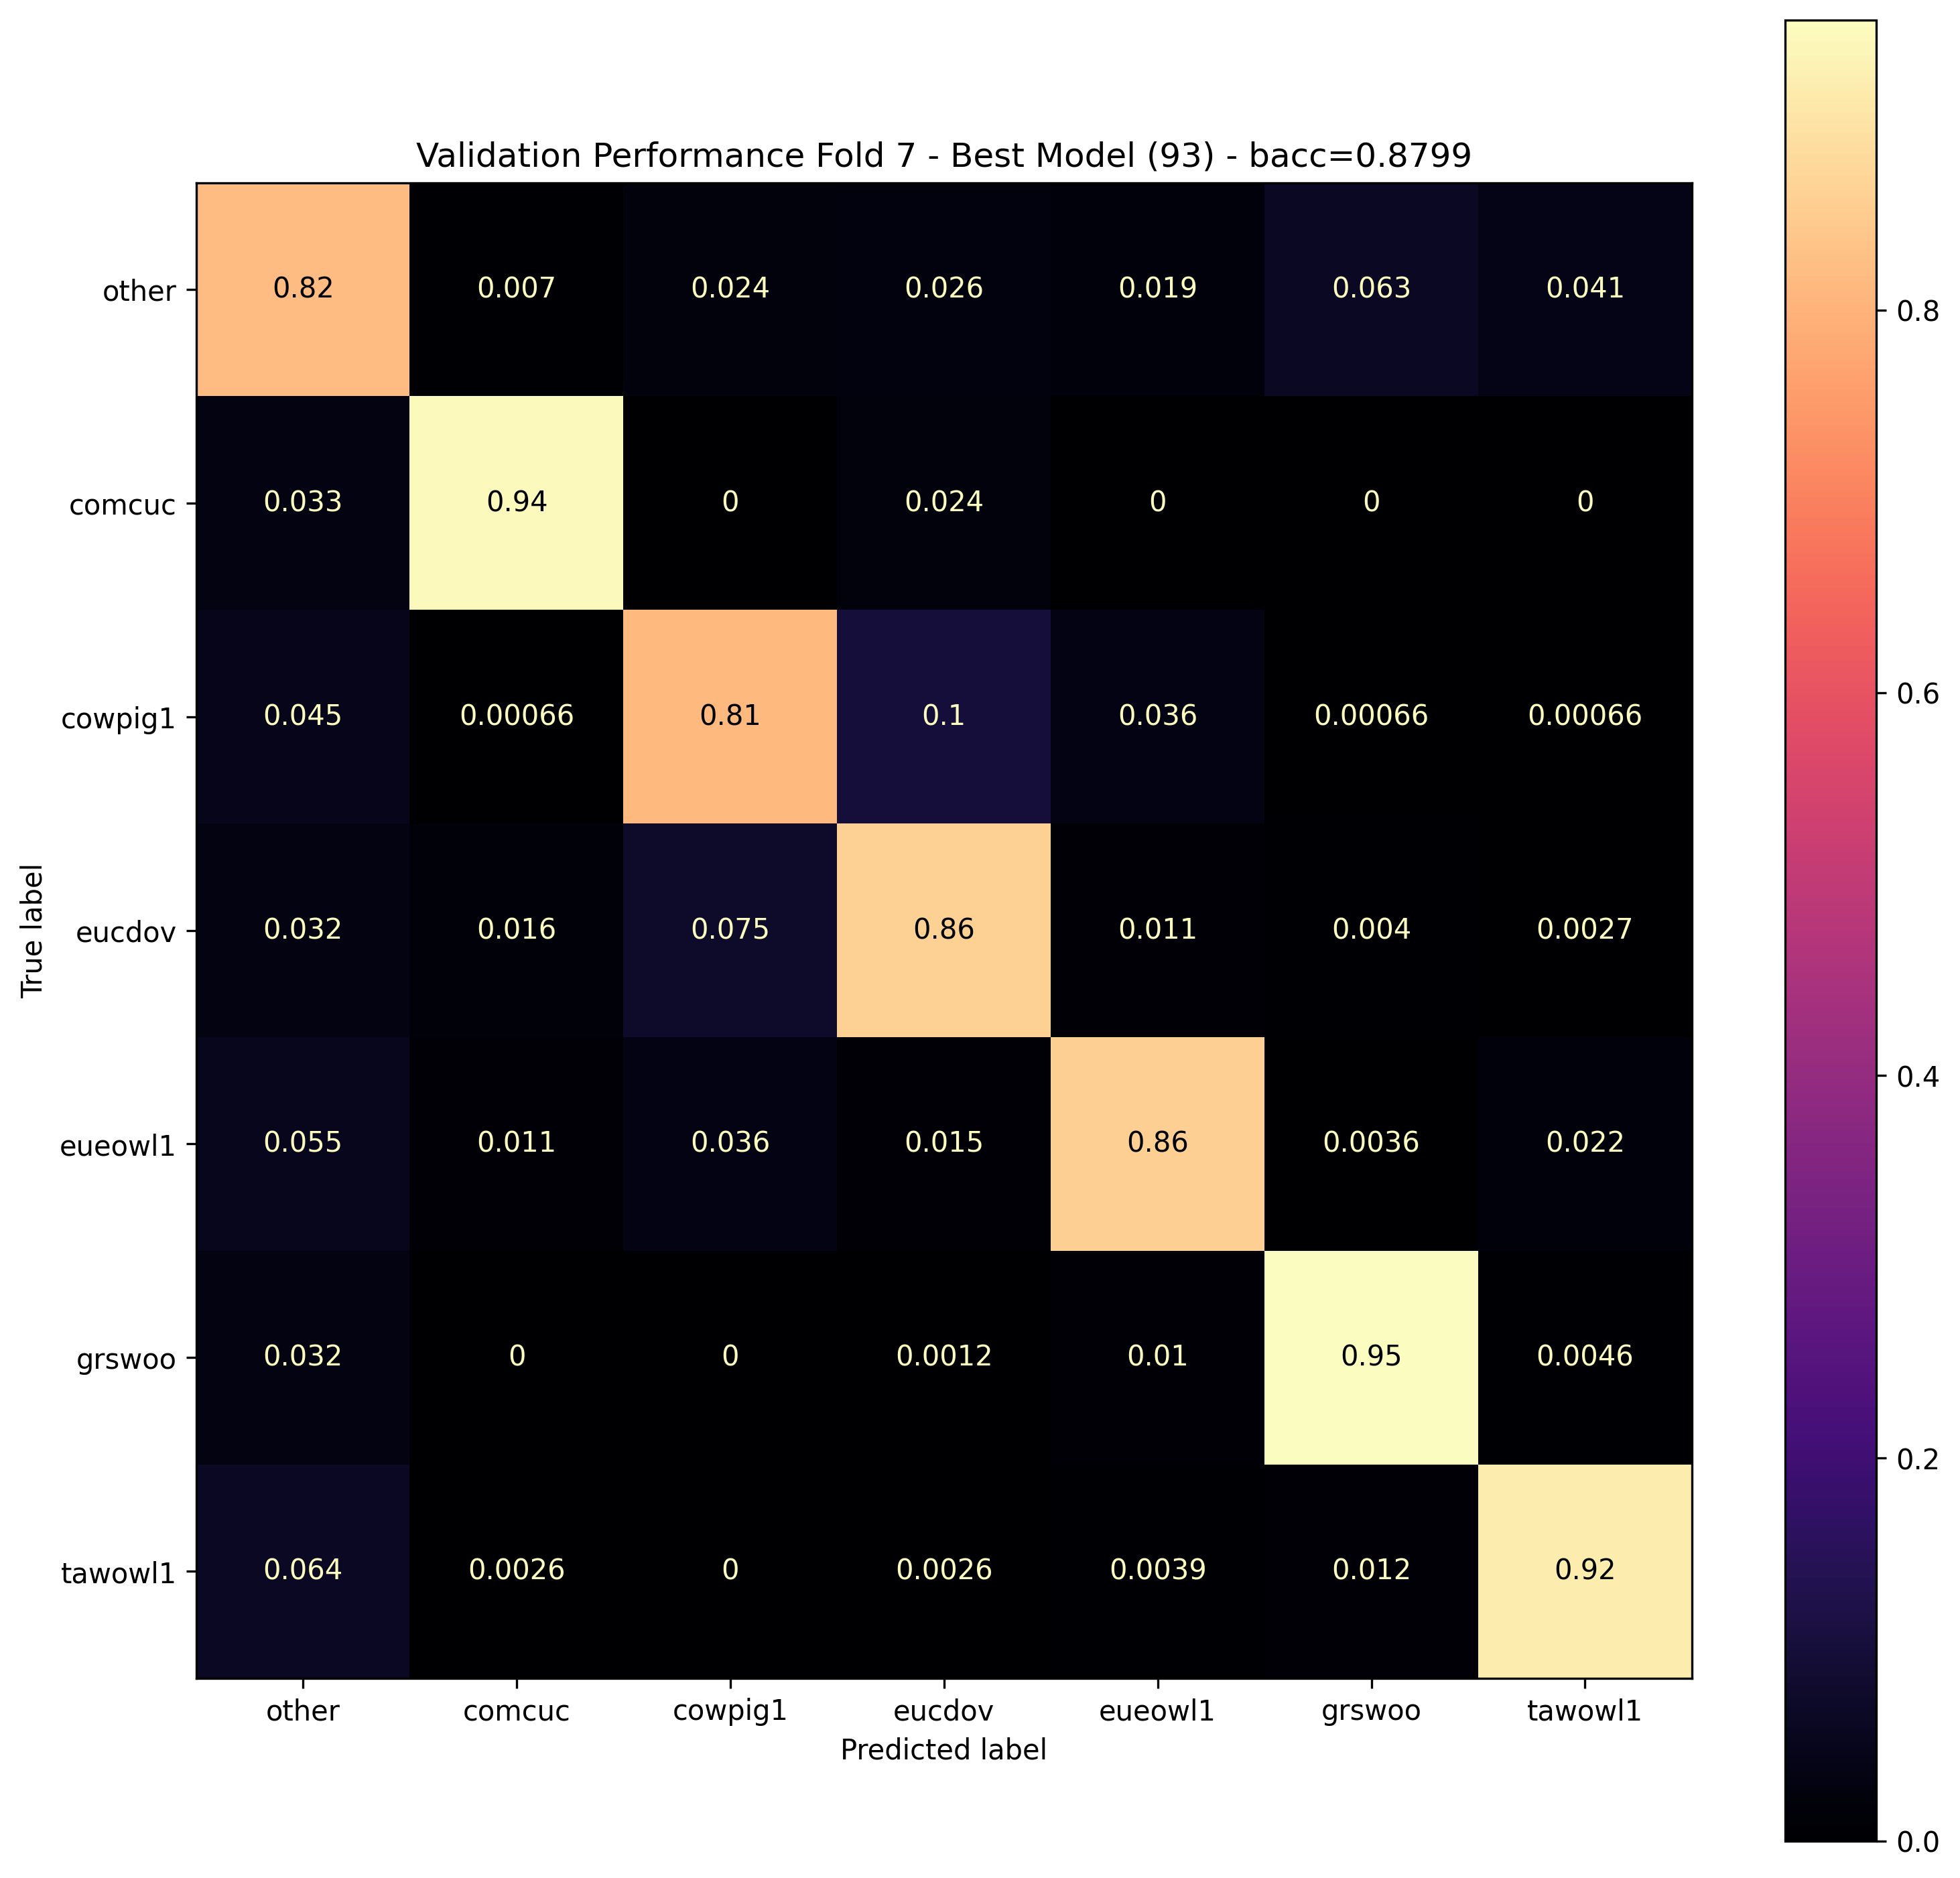

Saved model with scaler as "attention_classifier cv2023-06-05_18.56 fold-7-best train-bacc=0.9410 eval-bacc=0.8799"


#################
#### Metrics ####
#################


cv_average_best_best_models_eval_metrics = epoch = 152.750000, avg_loss = 0.000073, num_samples = 15000.000000, num_correct = 12690.750000, acc = 0.846050, bacc = 0.882860 


cv_final_epoch_avg_train_metrics = epoch = 300.000000, avg_loss = 0.000007, num_samples = 105000.000000, num_correct = 96722.375000, acc = 0.921165, bacc = 0.979364
cv_final_epoch_avg_eval_metrics  = epoch = 300.000000, avg_loss = 0.000082, num_samples = 15000.000000, num_correct = 13005.875000, acc = 0.867058, bacc = 0.868456


In [24]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    num_epochs=300,
    initial_lr=1e-3,
    lr_scheduler_milestones=[30, 100, 250],
    lr_scheduler_gamma=0.75,
)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    combined_ds,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_eval_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics = }')
print(f'{cv_final_epoch_avg_eval_metrics  = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

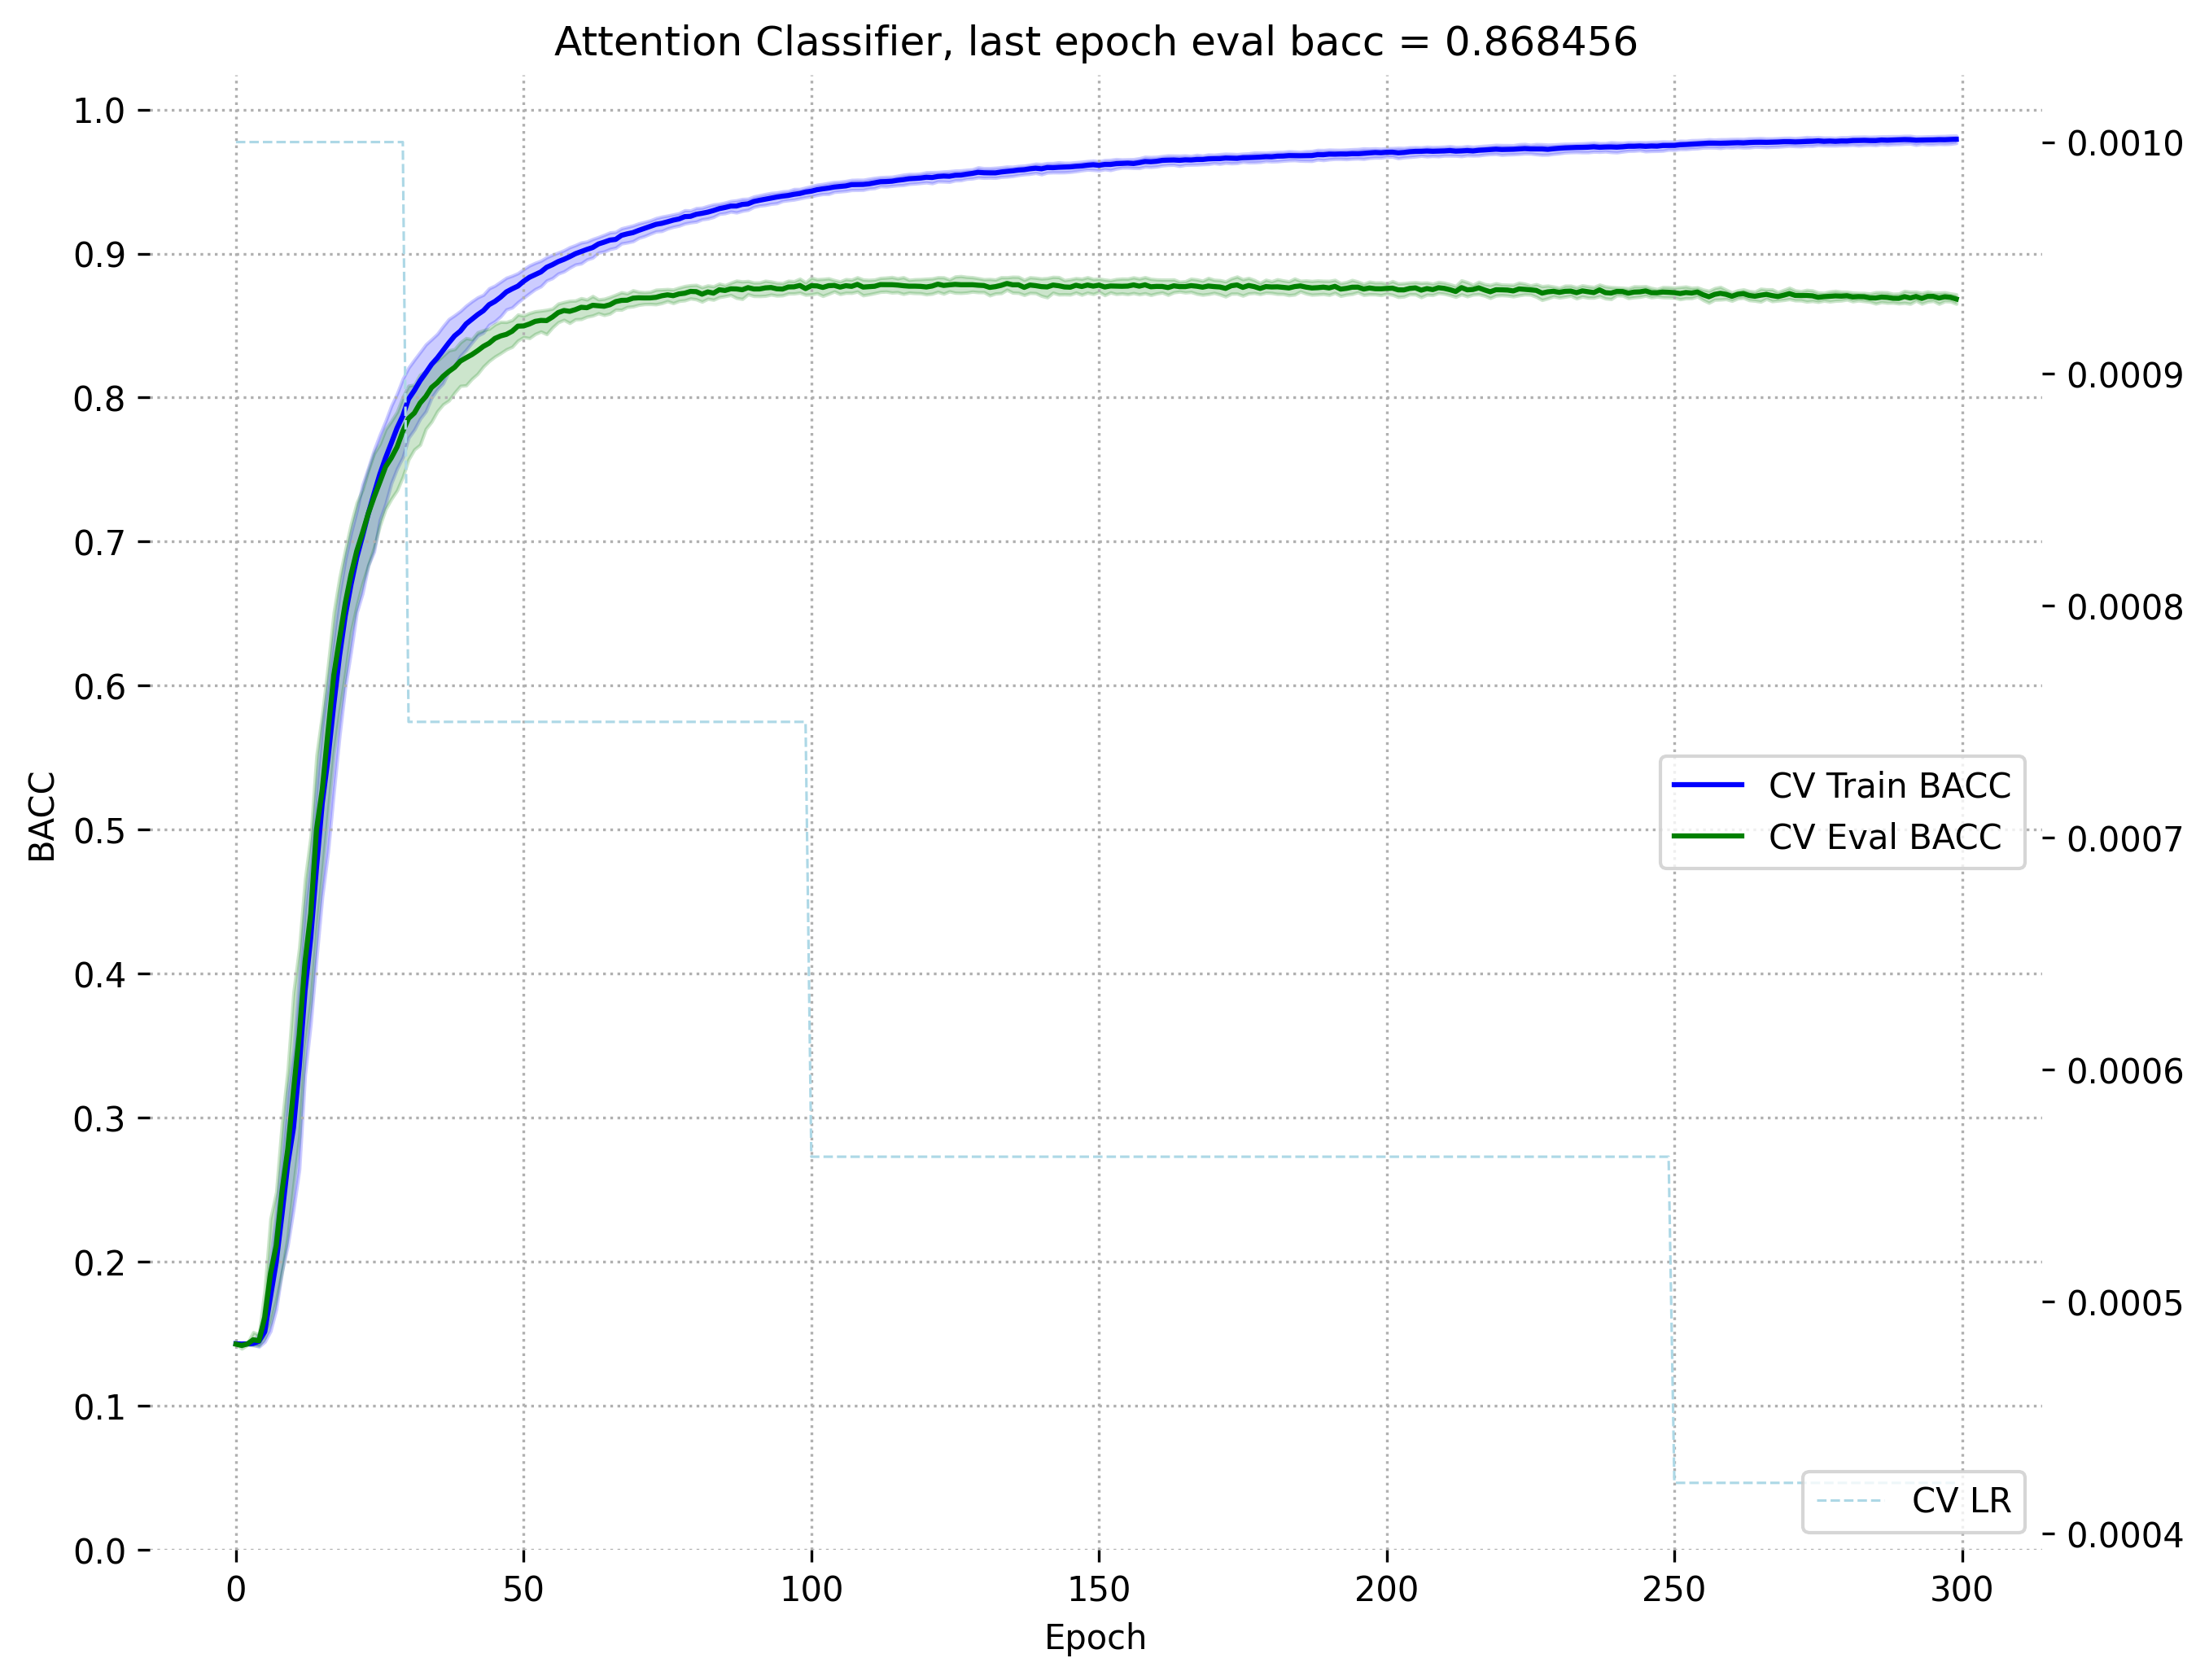

In [25]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')